# Analyze downstream partners of hair plate neurons

In [1]:
# Import libraries
import os

# viz_method = one of ['itkwidgets', 'vtk']
viz_method = 'vtk'

# this is the EM specific package for querying the EM data
from caveclient import CAVEclient

# import some of our favorite packages
import pandas as pd
import numpy as np
import os
import seaborn as sea
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
client = CAVEclient()

# if not os.path.isfile(os.path.expanduser("~/.cloudvolume/secrets/cave-secret.json")):
#     client.auth.get_new_token(open=True)

# if you have not yet setup this computer, uncomment this below line
# paste the token from the website in, and run the line

# client.auth.save_token(token="81369b6b6ae25048f4d0936a17307c39", overwrite=True) # THIS IS MY TOKEN!!!

# then comment or delete the line as you don't need to run it on this computer  again

datastack_name = 'fanc_production_mar2021'

client = CAVEclient(datastack_name)

In [57]:
# table information
client.materialize.get_tables()

['motor_neuron_table_v6',
 't1_leg_motor_neurons',
 'mn_classifications',
 't1_leg_motor_neuron_classifications',
 'sensory_axon_table',
 'motor_neuron_table',
 'motor_neuron_table_v2',
 'hair_plate_table',
 'motor_neuron_table_v4',
 'synapses_jan2022',
 'nerve_bundle_fibers_v0',
 'bristle_axon_table',
 'downstream_bristle_table_v0',
 'motor_neuron_table_v5',
 'motor_neuron_table_v7',
 'neurotransmitter_hemilineage_table',
 'soma_jan2022',
 'all_leg_motor_neuron_table_v0',
 'haltere_motor_neuron_table_v0',
 'neck_motor_neuron_table_v0',
 'neck_connective_tag_table_v0',
 'wing_premotor_table_v1',
 'neck_connective_tag_table_v1',
 'tibia_flexor_premotor_table',
 'femur_mn_premotor_table_v2']

### Query for syanpses

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now we are ready to query synapses for this neuron. Because the analysis database can, in principle, handle multiple different sources of synapses, we have to specify which synapse table we want to use. The current table holding the most up to date automated synapse detection is called `synapses_may2021`.  The "info" service has this information however, so we don't need to remember it.

Because synapses are such a common query, there is a wrapper method `synapse_query` which makes uses the default synapse table and simplifies the syntax. So, we can specify which synapses we get back from the table by setting the `post_ids` argument to a list of IDs (UPSTREAM), which makes a query that only returns synapses whose postsynaptic id is the one selected.  You can also filter by `pre_ids` which will do the same for the pre-synaptic side (DOWNSTREAM). Setting this will only return synapses that are from certain neurons.  Setting both `pre_ids` and `post_ids` will return only synapses that are from the `pre_ids` onto the `post_ids`.
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h3> Synapse Table Descriptions</h3>
Here's a breakdown of what each of those columns mean.
</div>

<table style={float:left}>
    <tr>
        <td><h4>column</h4></td>
        <td><h4>description</h4></td>
    </tr> 
    <tr>
        <td>id</td>
        <td>The ID that is specific to this synapse annotation</td>
    </tr>
    <tr>
        <td>pre_pt_supervoxel_id</td>
        <td>a bookkeeping column for the presynaptic side </td>
    </tr>
    <tr>
        <td>pre_pt_root_id</td>
        <td>the ID of the cell on the presynaptic side</td>
    </tr>
    <tr>
        <td>post_pt_supervoxel_id</td>
        <td>Same bookkeeping column as pre_pt but for the post synaptic side.</td>
    </tr>
    <tr>
        <td>post_pt_root_id</td>
        <td>Same as pre_pt but for the post synaptic side</td>
    </tr>
    <tr>
        <td>score</td>
        <td>The size of the synaptic cleft in units of 4.3,4.3,45 voxels.</td>
    </tr>
    <tr>
        <td>pre_pt_position</td>
        <td>a point that is in the pre-synaptic terminal of this synapse (in voxels) </td>
    </tr>
    <tr>
        <td>post_pt_position</td>
        <td>Same as pre_pt but for the post synaptic side.</td>
    </tr>

</table>
<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Each row in this table is a single synapse. You should see that the value in the post_pt_root_id column is the same for all, and equals the id you selected above. 
<h5>Note again that position columns are in voxel coordinates, just like Neuroglancer displays in the upper left corner. A single voxel has dimensions 4.3x4.3x45 nm.</h5>
</div>

### Hair-plate neuron information

In [4]:
hair_plate_neurons

NameError: name 'hair_plate_neurons' is not defined

In [4]:
# Hair Plate - extract labels and hair-plate segids
hp_table = client.materialize.query_table('hair_plate_table')
hp_id_list = []
for j in range(len(hp_table['pt_root_id'])):
    hp_id_list.append(hp_table['pt_root_id'].astype(str)[j][-4::])
hp_combined_label = hp_table['classification_system'] + ' - ' + hp_table['cell_type'] + ' (' + hp_id_list + ')'
hair_plate_identity = hp_combined_label.tolist()
hair_plate_neurons = hp_table['pt_root_id'].tolist()
hp_table

,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position
0,3,t,T1L_ProAN,CoHP4,72201700391479467,648518346498320945,"[5304, 101828, 3152]"
1,4,t,T1L_ProAN,CoHP4,72201700391510477,648518346486001800,"[5416, 101453, 3175]"
2,5,t,T1L_ProLN,TrHP 5-7,72272138123634795,648518346493028338,"[6870, 103194, 3651]"
3,7,t,T1L_ProLN,TrHP 5-7,72342438148477457,648518346501717065,"[8889, 100653, 3690]"
4,8,t,T1L_ProLN,TrHP 5-7,72272138123708580,648518346479317211,"[6692, 102941, 3680]"
5,9,t,T1L_ProLN,TrHP 5-7,72272069404320141,648518346500488883,"[7975, 102190, 3696]"
6,10,t,T1L_ProLN,TrHP 5-7,72272069404336512,648518346517170213,"[8011, 101788, 3696]"
7,11,t,T1L_ProLN,TrHP 5-7,72272138190601791,648518346500341939,"[8087, 103705, 3729]"
8,12,t,T1L_VProN,CoHP8,72412531678958628,648518346486034056,"[11367, 93032, 2963]"
9,13,t,T1L_VProN,CoHP8,72412531678972212,648518346465846832,"[11323, 92690, 2963]"


In [5]:
# isolate only left side hair-plates
L_hps_ids = []
L_hps_name = []
R_hps_ids = []
R_hps_name = []
for j in range(len(hp_table['classification_system'])):
    loc = hp_table['classification_system'][j][0:3]
    if loc == 'T1L':
        L_hps_ids.append(hp_table['pt_root_id'][j])
        if hp_table['cell_type'][j][0:4] == 'TrHP':
            L_hps_name.append('Unidentified HP')
        else: 
            L_hps_name.append(hp_table['cell_type'][j])
    else:
        R_hps_ids.append(hp_table['pt_root_id'][j])
        R_hps_name.append(hp_table['cell_type'][j])
        
        
            
            
sorted_hp_idxs = np.argsort(np.array(L_hps_name))
L_hps_name = np.array(L_hps_name)[sorted_hp_idxs].tolist()
L_hps_ids = np.array(L_hps_ids)[sorted_hp_idxs].tolist()

# add additionally found CoHP 8 neurons 
R_hps_ids = np.concatenate((np.array(R_hps_ids), np.array([648518346517204840, 648518346493638904])))
R_hps_name = np.concatenate((np.array(R_hps_name), np.array(['CoHP8', 'CoHP8'])))

# append new hair-plate
L_hps_ids.append(648518346479794676)
L_hps_name.append('Unidentified HP')


### motor neuron information

In [6]:
mn_table = client.materialize.query_table('motor_neuron_table_v7')
mn_identity = []
mn_pos = []
for j in range(len(mn_table['cell_type'])):
    mn_identity.append(mn_table['cell_type'][j].replace("_", " "))
    mn_pos.append(mn_table['classification_system'][j][-3::])
mn_ids = mn_table['pt_root_id'].tolist()

# Filter for T1L motor neurons
mn_t1l = np.array(mn_ids)[np.array(mn_pos) == 'T1L'].tolist()
mn_target_t1l = np.array(mn_identity)[np.array(mn_pos) == 'T1L'].tolist()

mns_unsorted, mn_indices = np.unique(np.array(mn_t1l), return_index = True)
sort_idxs = np.argsort(mn_indices)
mn_t1l= mns_unsorted[sort_idxs].tolist()
mn_identity = np.array(mn_identity)[mn_indices.tolist()]
mn_target_t1l = mn_identity[sort_idxs].tolist()

mn_table[0:10]

,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position
0,291,t,D1_T1L,tergopleural_promotor_pleural_promotor_in_thor...,72975343790906622,648518346472480777,"[28385, 88521, 2251]"
1,279,t,A1_T1L,sternal_posterior_rotator_in_thorax_miller_32,72483655733552219,648518346494806962,"[12726, 115166, 1861]"
2,282,t,A1_T1L,sternal_posterior_rotator_in_thorax_miller_32,72342986830511451,648518346501837930,"[9590, 117780, 1629]"
3,284,t,A4_T1L,pleural_remotor_and_abductor_in_thorax_miller_29,72693868814306475,648518346486098834,"[19270, 88811, 2289]"
4,286,t,A2_T1L,trochanter_flexor_in_coxa_AcPst,72483655666524185,648518346486120840,"[14058, 115317, 1758]"
5,287,t,A2_T1L,trochanter_flexor_in_coxa_AcPst,72413355373453175,648518346483181988,"[10872, 118153, 1266]"
6,288,t,A3_T1L,trochanter_flexor_in_coxa_Ac,72623431283432202,648518346499251291,"[17583, 86886, 2142]"
7,289,t,A3_T1L,trochanter_flexor_in_coxa_Ac,72834468863862859,648518346517668968,"[22736, 85820, 2309]"
8,290,t,A3_T1L,trochanter_flexor_in_coxa_Ac,72764168838880663,648518346483112382,"[21575, 87200, 2242]"
9,292,t,D1_T1L,tergopleural_promotor_pleural_promotor_in_thor...,72975275004512296,648518346490347612,"[26759, 87253, 2174]"


In [17]:
np.unique(np.array(mn_t1l)).shape

(69,)

In [16]:
a = mn_table[mn_table['pt_root_id']==648518346472369611]
np.array(a['cell_type'])

array(['tergopleural_promotor_pleural_promotor_miller_28_30'],
      dtype=object)

### hemilineage analysis

In [59]:
hm_table = client.materialize.query_table('neurotransmitter_hemilineage_table')
hm_table

,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position
0,1,t,Cholinergic,1A,72696204940815199,648518346483664815,"[20040, 157696, 1601]"
1,2,t,Cholinergic,1A,74031905544403361,648518346483699887,"[59368, 120200, 1844]"
2,3,t,Cholinergic,1A,74172711618189237,648518346489340249,"[62608, 121320, 1642]"
3,4,t,Cholinergic,1A,72766573685022298,648518346479402176,"[21576, 158192, 1570]"
4,5,t,Cholinergic,1A,74031905611506958,648518346490035409,"[57520, 120032, 1945]"
...,...,...,...,...,...,...,...
307,103,t,Cholinergic,23B,72624393020815762,648518346502418246,"[17920, 116312, 1540]"
308,121,t,Cholinergic,23B,72554230300874791,648518346486674940,"[15240, 121024, 1270]"
309,100,t,Cholinergic,23B,72624530258178138,648518346502416454,"[17048, 120464, 1060]"
310,122,t,Cholinergic,23B,72483792769799839,648518346477676439,"[13800, 118976, 1066]"


In [67]:
hm_ids = hm_table['pt_root_id'].tolist()
hm_name = hm_table['cell_type'].values + ' - ' + hm_table['classification_system'].values 
hm_name = hm_name.tolist()

## Connectivity Analyses

In [7]:
# create color map
from matplotlib.colors import LinearSegmentedColormap
# 0.2422, 0.1504, 0.6603
cm_data = [[0.0, 0.0, 0.0],
[0.2444, 0.1534, 0.6728],
[0.2464, 0.1569, 0.6847],
[0.2484, 0.1607, 0.6961],
[0.2503, 0.1648, 0.7071],
[0.2522, 0.1689, 0.7179],
[0.254, 0.1732, 0.7286],
[0.2558, 0.1773, 0.7393],
[0.2576, 0.1814, 0.7501],
[0.2594, 0.1854, 0.761],
[0.2611, 0.1893, 0.7719],
[0.2628, 0.1932, 0.7828],
[0.2645, 0.1972, 0.7937],
[0.2661, 0.2011, 0.8043],
[0.2676, 0.2052, 0.8148],
[0.2691, 0.2094, 0.8249],
[0.2704, 0.2138, 0.8346],
[0.2717, 0.2184, 0.8439],
[0.2729, 0.2231, 0.8528],
[0.274, 0.228, 0.8612],
[0.2749, 0.233, 0.8692],
[0.2758, 0.2382, 0.8767],
[0.2766, 0.2435, 0.884],
[0.2774, 0.2489, 0.8908],
[0.2781, 0.2543, 0.8973],
[0.2788, 0.2598, 0.9035],
[0.2794, 0.2653, 0.9094],
[0.2798, 0.2708, 0.915],
[0.2802, 0.2764, 0.9204],
[0.2806, 0.2819, 0.9255],
[0.2809, 0.2875, 0.9305],
[0.2811, 0.293, 0.9352],
[0.2813, 0.2985, 0.9397],
[0.2814, 0.304, 0.9441],
[0.2814, 0.3095, 0.9483],
[0.2813, 0.315, 0.9524],
[0.2811, 0.3204, 0.9563],
[0.2809, 0.3259, 0.96],
[0.2807, 0.3313, 0.9636],
[0.2803, 0.3367, 0.967],
[0.2798, 0.3421, 0.9702],
[0.2791, 0.3475, 0.9733],
[0.2784, 0.3529, 0.9763],
[0.2776, 0.3583, 0.9791],
[0.2766, 0.3638, 0.9817],
[0.2754, 0.3693, 0.984],
[0.2741, 0.3748, 0.9862],
[0.2726, 0.3804, 0.9881],
[0.271, 0.386, 0.9898],
[0.2691, 0.3916, 0.9912],
[0.267, 0.3973, 0.9924],
[0.2647, 0.403, 0.9935],
[0.2621, 0.4088, 0.9946],
[0.2591, 0.4145, 0.9955],
[0.2556, 0.4203, 0.9965],
[0.2517, 0.4261, 0.9974],
[0.2473, 0.4319, 0.9983],
[0.2424, 0.4378, 0.9991],
[0.2369, 0.4437, 0.9996],
[0.2311, 0.4497, 0.9995],
[0.225, 0.4559, 0.9985],
[0.2189, 0.462, 0.9968],
[0.2128, 0.4682, 0.9948],
[0.2066, 0.4743, 0.9926],
[0.2006, 0.4803, 0.9906],
[0.195, 0.4861, 0.9887],
[0.1903, 0.4919, 0.9867],
[0.1869, 0.4975, 0.9844],
[0.1847, 0.503, 0.9819],
[0.1831, 0.5084, 0.9793],
[0.1818, 0.5138, 0.9766],
[0.1806, 0.5191, 0.9738],
[0.1795, 0.5244, 0.9709],
[0.1785, 0.5296, 0.9677],
[0.1778, 0.5349, 0.9641],
[0.1773, 0.5401, 0.9602],
[0.1768, 0.5452, 0.956],
[0.1764, 0.5504, 0.9516],
[0.1755, 0.5554, 0.9473],
[0.174, 0.5605, 0.9432],
[0.1716, 0.5655, 0.9393],
[0.1686, 0.5705, 0.9357],
[0.1649, 0.5755, 0.9323],
[0.161, 0.5805, 0.9289],
[0.1573, 0.5854, 0.9254],
[0.154, 0.5902, 0.9218],
[0.1513, 0.595, 0.9182],
[0.1492, 0.5997, 0.9147],
[0.1475, 0.6043, 0.9113],
[0.1461, 0.6089, 0.908],
[0.1446, 0.6135, 0.905],
[0.1429, 0.618, 0.9022],
[0.1408, 0.6226, 0.8998],
[0.1383, 0.6272, 0.8975],
[0.1354, 0.6317, 0.8953],
[0.1321, 0.6363, 0.8932],
[0.1288, 0.6408, 0.891],
[0.1253, 0.6453, 0.8887],
[0.1219, 0.6497, 0.8862],
[0.1185, 0.6541, 0.8834],
[0.1152, 0.6584, 0.8804],
[0.1119, 0.6627, 0.877],
[0.1085, 0.6669, 0.8734],
[0.1048, 0.671, 0.8695],
[0.1009, 0.675, 0.8653],
[0.0964, 0.6789, 0.8609],
[0.0914, 0.6828, 0.8562],
[0.0855, 0.6865, 0.8513],
[0.0789, 0.6902, 0.8462],
[0.0713, 0.6938, 0.8409],
[0.0628, 0.6972, 0.8355],
[0.0535, 0.7006, 0.8299],
[0.0433, 0.7039, 0.8242],
[0.0328, 0.7071, 0.8183],
[0.0234, 0.7103, 0.8124],
[0.0155, 0.7133, 0.8064],
[0.0091, 0.7163, 0.8003],
[0.0046, 0.7192, 0.7941],
[0.0019, 0.722, 0.7878],
[0.0009, 0.7248, 0.7815],
[0.0018, 0.7275, 0.7752],
[0.0046, 0.7301, 0.7688],
[0.0094, 0.7327, 0.7623],
[0.0162, 0.7352, 0.7558],
[0.0253, 0.7376, 0.7492],
[0.0369, 0.74, 0.7426],
[0.0504, 0.7423, 0.7359],
[0.0638, 0.7446, 0.7292],
[0.077, 0.7468, 0.7224],
[0.0899, 0.7489, 0.7156],
[0.1023, 0.751, 0.7088],
[0.1141, 0.7531, 0.7019],
[0.1252, 0.7552, 0.695],
[0.1354, 0.7572, 0.6881],
[0.1448, 0.7593, 0.6812],
[0.1532, 0.7614, 0.6741],
[0.1609, 0.7635, 0.6671],
[0.1678, 0.7656, 0.6599],
[0.1741, 0.7678, 0.6527],
[0.1799, 0.7699, 0.6454],
[0.1853, 0.7721, 0.6379],
[0.1905, 0.7743, 0.6303],
[0.1954, 0.7765, 0.6225],
[0.2003, 0.7787, 0.6146],
[0.2061, 0.7808, 0.6065],
[0.2118, 0.7828, 0.5983],
[0.2178, 0.7849, 0.5899],
[0.2244, 0.7869, 0.5813],
[0.2318, 0.7887, 0.5725],
[0.2401, 0.7905, 0.5636],
[0.2491, 0.7922, 0.5546],
[0.2589, 0.7937, 0.5454],
[0.2695, 0.7951, 0.536],
[0.2809, 0.7964, 0.5266],
[0.2929, 0.7975, 0.517],
[0.3052, 0.7985, 0.5074],
[0.3176, 0.7994, 0.4975],
[0.3301, 0.8002, 0.4876],
[0.3424, 0.8009, 0.4774],
[0.3548, 0.8016, 0.4669],
[0.3671, 0.8021, 0.4563],
[0.3795, 0.8026, 0.4454],
[0.3921, 0.8029, 0.4344],
[0.405, 0.8031, 0.4233],
[0.4184, 0.803, 0.4122],
[0.4322, 0.8028, 0.4013],
[0.4463, 0.8024, 0.3904],
[0.4608, 0.8018, 0.3797],
[0.4753, 0.8011, 0.3691],
[0.4899, 0.8002, 0.3586],
[0.5044, 0.7993, 0.348],
[0.5187, 0.7982, 0.3374],
[0.5329, 0.797, 0.3267],
[0.547, 0.7957, 0.3159],
[0.5609, 0.7943, 0.305],
[0.5748, 0.7929, 0.2941],
[0.5886, 0.7913, 0.2833],
[0.6024, 0.7896, 0.2726],
[0.6161, 0.7878, 0.2622],
[0.6297, 0.7859, 0.2521],
[0.6433, 0.7839, 0.2423],
[0.6567, 0.7818, 0.2329],
[0.6701, 0.7796, 0.2239],
[0.6833, 0.7773, 0.2155],
[0.6963, 0.775, 0.2075],
[0.7091, 0.7727, 0.1998],
[0.7218, 0.7703, 0.1924],
[0.7344, 0.7679, 0.1852],
[0.7468, 0.7654, 0.1782],
[0.759, 0.7629, 0.1717],
[0.771, 0.7604, 0.1658],
[0.7829, 0.7579, 0.1608],
[0.7945, 0.7554, 0.157],
[0.806, 0.7529, 0.1546],
[0.8172, 0.7505, 0.1535],
[0.8281, 0.7481, 0.1536],
[0.8389, 0.7457, 0.1546],
[0.8495, 0.7435, 0.1564],
[0.86, 0.7413, 0.1587],
[0.8703, 0.7392, 0.1615],
[0.8804, 0.7372, 0.165],
[0.8903, 0.7353, 0.1695],
[0.9, 0.7336, 0.1749],
[0.9093, 0.7321, 0.1815],
[0.9184, 0.7308, 0.189],
[0.9272, 0.7298, 0.1973],
[0.9357, 0.729, 0.2061],
[0.944, 0.7285, 0.2151],
[0.9523, 0.7284, 0.2237],
[0.9606, 0.7285, 0.2312],
[0.9689, 0.7292, 0.2373],
[0.977, 0.7304, 0.2418],
[0.9842, 0.733, 0.2446],
[0.99, 0.7365, 0.2429],
[0.9946, 0.7407, 0.2394],
[0.9966, 0.7458, 0.2351],
[0.9971, 0.7513, 0.2309],
[0.9972, 0.7569, 0.2267],
[0.9971, 0.7626, 0.2224],
[0.9969, 0.7683, 0.2181],
[0.9966, 0.774, 0.2138],
[0.9962, 0.7798, 0.2095],
[0.9957, 0.7856, 0.2053],
[0.9949, 0.7915, 0.2012],
[0.9938, 0.7974, 0.1974],
[0.9923, 0.8034, 0.1939],
[0.9906, 0.8095, 0.1906],
[0.9885, 0.8156, 0.1875],
[0.9861, 0.8218, 0.1846],
[0.9835, 0.828, 0.1817],
[0.9807, 0.8342, 0.1787],
[0.9778, 0.8404, 0.1757],
[0.9748, 0.8467, 0.1726],
[0.972, 0.8529, 0.1695],
[0.9694, 0.8591, 0.1665],
[0.9671, 0.8654, 0.1636],
[0.9651, 0.8716, 0.1608],
[0.9634, 0.8778, 0.1582],
[0.9619, 0.884, 0.1557],
[0.9608, 0.8902, 0.1532],
[0.9601, 0.8963, 0.1507],
[0.9596, 0.9023, 0.148],
[0.9595, 0.9084, 0.145],
[0.9597, 0.9143, 0.1418],
[0.9601, 0.9203, 0.1382],
[0.9608, 0.9262, 0.1344],
[0.9618, 0.932, 0.1304],
[0.9629, 0.9379, 0.1261],
[0.9642, 0.9437, 0.1216],
[0.9657, 0.9494, 0.1168],
[0.9674, 0.9552, 0.1116],
[0.9692, 0.9609, 0.1061],
[0.9711, 0.9667, 0.1001],
[0.973, 0.9724, 0.0938],
[0.9749, 0.9782, 0.0872],
[0.9769, 0.9839, 0.0805]]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)

In [68]:
# Hierarchical clustering of similarity matrix
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    dend_dict = dendrogram(linkage_matrix, **kwargs)
    
    # sorted order of indices found through clustering
    clustered_order = dend_dict['ivl']
    plt.close()
    
    return clustered_order

In [69]:
# downstream neurons from hair-plate neurons - ONLY HAIR_PLATES IN T1L
post_synapse_df = client.materialize.synapse_query(pre_ids = L_hps_ids) 
# post_synapse_df = client.materialize.synapse_query(pre_ids = hair_plate_neurons) 
hp_df_store =[]
# for hp_id in hair_plate_neurons:
for hp_id in L_hps_ids:
    # hair plate specific data frame sorted by the strongest synapse
    hp_post_df = post_synapse_df[post_synapse_df['pre_pt_root_id'] == hp_id]
    hp_post_synapses = hp_post_df.groupby(['pre_pt_root_id','post_pt_root_id'])['post_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)
    
    # append this dataframe
    hp_df_store.append(hp_post_synapses)

### Hair-plate neurons onto motor neurons

In [73]:
def create_ordered_connectivity_matrix(cell_type_1_table, cell_type_1_labels, cell_type_2_seg_ids, cell_type_2_labels, x_axis_label, y_axis_label, figure_size, ytick_fontsize, xtick_fontsize, save_path):
    # hair plate and motor neuron connectivity matrix
    connectivity_mat = np.zeros((len(cell_type_1_table), len(cell_type_2_seg_ids)))
    for j in range(len(cell_type_1_table)):
        for i in range(len(cell_type_2_seg_ids)):
            if cell_type_2_seg_ids[i] in cell_type_1_table[j]['post_pt_root_id'].values:
                connectivity_mat[j, i] = cell_type_1_table[j]['number_of_synapses'][cell_type_1_table[j]['post_pt_root_id']==cell_type_2_seg_ids[i]].values


    # Prune matrix to include only those motor neurons that recieve input from hair plates
    prunned_labels = []
    remaining_labels = []
    temp_mat =[]
    for j in range(len(cell_type_2_seg_ids)):
        if np.sum(connectivity_mat[:,j]) == 0:
            prunned_labels.append(cell_type_2_seg_ids[j])
        else:
            remaining_labels.append(cell_type_2_labels[j])
            temp_mat.append(connectivity_mat[:,j])

    if len(remaining_labels) == 0:
        print('no connectivity')
        stop_clause = 0
    else:
        stop_clause = 1

    if stop_clause == 1:  
        prunned_mat = np.zeros((len(temp_mat[0]), len(temp_mat)))
        for i in range(len(temp_mat)):
            prunned_mat[:,i] = temp_mat[i] 

        # cosine similarity on cell type 1
        sim_mat_1 = cosine_similarity(prunned_mat)
        model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat_1)
        clustered_order_1 = plot_dendrogram(model, truncate_mode="level", p=len(cell_type_1_table)) # p truncate mode
        clustered_order_1 = np.array(clustered_order_1).astype(int) # convert strins into integers

        # reorder hairplate and motor neuron matrix
        reorder_mat = prunned_mat[clustered_order_1, :]

        # Cosine similarity on cell type 2
        sim_mat_2 = cosine_similarity(np.transpose(prunned_mat))

        # setting distance_threshold=0 ensures we compute the full tree.
        model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat_2)
        clustered_order_2 = plot_dendrogram(model, truncate_mode="level", p=len(cell_type_2_seg_ids)) # p truncate mode
        clustered_order_2 = np.array(clustered_order_2).astype(int) # convert strins into integers

        # reorder hairplate and motor neuron matrix
        reordered_mat_2 = reorder_mat[:, clustered_order_2]

        # visualize prunned matrix
        fig = plt.figure(1, figsize = figure_size)
        ax = sea.heatmap(reordered_mat_2, xticklabels=np.array(remaining_labels)[clustered_order_2].tolist(), yticklabels=np.array(cell_type_1_labels)[clustered_order_1].tolist(), cmap=parula_map)
        cbar = ax.collections[0].colorbar
        # here set the labelsize by 20
        cbar.ax.tick_params(labelsize=20)
        cbar.set_label(label = 'number of synapses', size=figure_size[1])
        plt.xlabel(x_axis_label, fontsize =18)
        plt.ylabel(y_axis_label, fontsize =18)
        plt.yticks(fontsize = ytick_fontsize)
        plt.xticks(fontsize = xtick_fontsize,rotation = 90)
        plt.show()
        fig.savefig(save_path, dpi = 200, bbox_inches = 'tight')


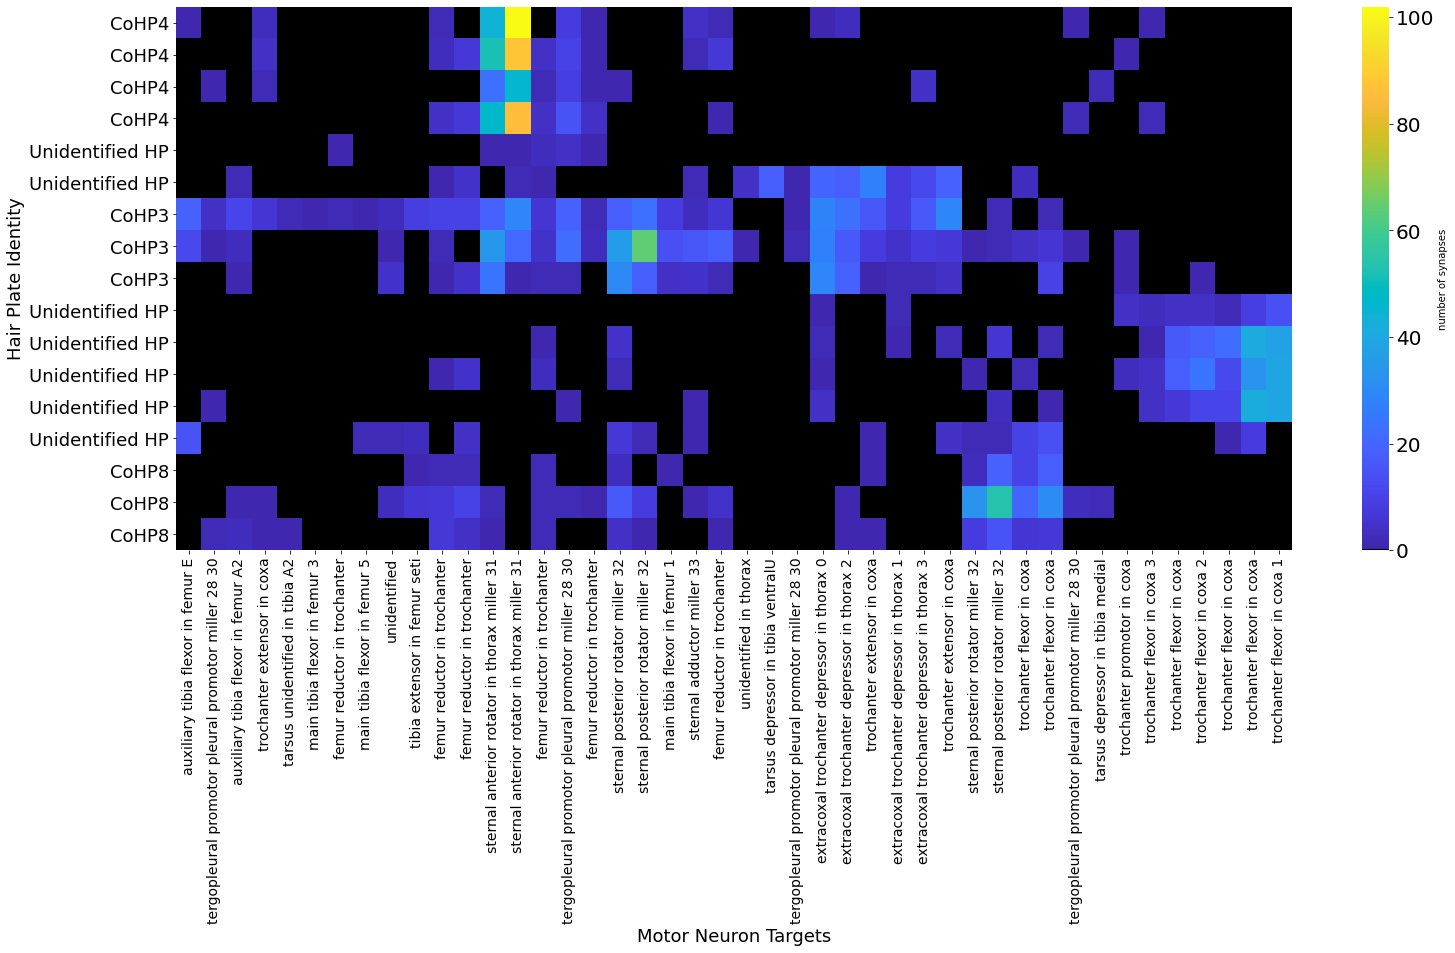

PermissionError: [Errno 13] Permission denied: 'C:/Users/pratt/Desktop/tuthill_lab/conferences/Neuronal Circuits 2022/hp_mn_connectivity.pdf'

In [106]:
save_path = 'C:/Users/pratt/Desktop/tuthill_lab/conferences/Neuronal Circuits 2022/hp_mn_connectivity.pdf'
x_axis_label = 'Motor Neuron Targets'
y_axis_label = 'Hair Plate Identity'
figure_size = [25,10]
ytick_fontsize = 18
xtick_fontsize = 14
create_ordered_connectivity_matrix(hp_df_store, L_hps_name, mns, mn_identity, x_axis_label, y_axis_label, 
                                   figure_size, ytick_fontsize, xtick_fontsize, save_path)

### T1L Hair-plate neuron input onto interneurons that synapse onto T1L motor neurons

In [50]:
L_hps_name[7:10]

['CoHP8', 'CoHP8', 'CoHP8']

In [51]:
coxa_hp_ids = L_hps_ids[7:10]
coxa_hp_name = L_hps_name[7:10]

In [52]:
# downstream neurons from hair-plate neurons - ONLY HAIR_PLATES IN T1L
syn_threshold = 5 # synapse threshold
hp_interneuron_df = client.materialize.synapse_query(pre_ids = coxa_hp_ids) 
hp_int_df_store = []

hp_cnt = 0
# for hp_id in hair_plate_neurons:
for hp_id in L_hps_ids:
    # hair plate specific data frame sorted by the strongest synapse
    hp_int_df = hp_interneuron_df[hp_interneuron_df['pre_pt_root_id'] == hp_id]
    hp_int_synapses = hp_int_df.groupby(['pre_pt_root_id','post_pt_root_id'])['post_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)
    filt_hp_int_df = hp_int_synapses[["post_pt_root_id", "number_of_synapses"]][hp_int_synapses['number_of_synapses'] > syn_threshold]
    
    # append this dataframe
    hp_int_df_store.append(filt_hp_int_df)
    


In [53]:
# Note can't do all motor neurons or interneurons at once because the table will be limited (too large)
start_cnt = 0
for j in range(len(hp_int_df_store)):
    curr_interneuron_ids = hp_int_df_store[j]['post_pt_root_id'].tolist()
    interneuron_df = client.materialize.synapse_query(pre_ids = curr_interneuron_ids)
    
    id_cnt = -1
    for id in curr_interneuron_ids:
        id_cnt += 1
        # hair plate specific data frame sorted by the strongest synapse
        int_df = interneuron_df[interneuron_df['pre_pt_root_id'] == id]
        int_synapses = int_df.groupby(['pre_pt_root_id','post_pt_root_id'])['post_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)
        
        # know see if this interneuron synapses onto a motor neuron in T1L
        mn_cnt = -1
        for mn in mn_t1l:
            mn_cnt += 1
            # if motor neuron is present then append relevant information to previous data frame
            if np.any(int_synapses['post_pt_root_id'] == mn):
                int_mn = int_synapses[int_synapses['post_pt_root_id'] == mn]

                # check to see if the interneuron synapses onto the motor neuron strongly (threshold > 10)
                if int_mn.reset_index()['number_of_synapses'][0] > syn_threshold:
                    if start_cnt == 0:
                        d = {'interneuron segid': [id], 'hp name': [L_hps_name[j]], 'hp seg id': [L_hps_ids[j]], 'num hp_int synapses': [hp_int_df_store[j]['number_of_synapses'][id_cnt]],
                               'mn target': [mn_target_t1l[mn_cnt]],'mn seg id': [mn], 'num int_mn synapses': [np.array(int_mn['number_of_synapses'])[0]]}
                        hp_int_md_df = pd.DataFrame(data=d)
                        start_cnt = 1
                    else:
                        d = {'interneuron segid': [id], 'hp name': [L_hps_name[j]], 'hp seg id': [L_hps_ids[j]], 'num hp_int synapses': [hp_int_df_store[j]['number_of_synapses'][id_cnt]],
                               'mn target': [mn_target_t1l[mn_cnt]],'mn seg id': [mn], 'num int_mn synapses': [np.array(int_mn['number_of_synapses'])[0]]}
                        hp_int_md_df = pd.concat([hp_int_md_df, pd.DataFrame(data=d)])
                        
                

    
# format dataframe
hp_int_md_df = hp_int_md_df.reset_index(drop=True)

In [22]:
hp_int_md_df

,interneuron segid,hp name,hp seg id,num hp_int synapses,mn target,mn seg id,num int_mn synapses
0,648518346489360985,CoHP3,648518346483962397,200,trochanter flexor in coxa Vn,648518346489322585,16
1,648518346489360985,CoHP3,648518346483962397,200,trochanter flexor in coxa Vn,648518346478862543,13
2,648518346490985592,CoHP3,648518346483962397,51,sternal anterior rotator in thorax miller 31,648518346496721965,11
3,648518346496915864,CoHP3,648518346483962397,51,trochanter flexor in coxa Ac,648518346517668968,18
4,648518346496915864,CoHP3,648518346483962397,51,trochanter flexor in coxa Ac,648518346483112382,34
...,...,...,...,...,...,...,...
863,648518346477555726,CoHP8,648518346518692063,12,sternal posterior rotator in thorax miller 32,648518346494371048,35
864,648518346477555726,CoHP8,648518346518692063,12,sternal posterior rotator in thorax miller 32,648518346526230999,39
865,648518346489484396,CoHP8,648518346518692063,11,tergotrochanter in thorax 2,648518346531258650,13
866,648518346489484396,CoHP8,648518346518692063,11,sternal anterior rotator in thorax miller 31,648518346496721965,42


In [54]:
# create hp - interneuron and interneuron - mn connectivity matrices
hp_segid = np.unique(hp_int_md_df['hp seg id'].values)
int_segid = np.unique(hp_int_md_df['interneuron segid'].values)
hp_int_connectivity_mat = np.zeros((hp_segid.shape[0], int_segid.shape[0]))
hp_type = []
int_type = []
for j in range(hp_segid.shape[0]):
    hp_type.append(hp_int_md_df[hp_int_md_df['hp seg id'] == hp_segid[j]]['hp name'].values[0])
    for i in range(int_segid.shape[0]):
        curr_ints = hp_int_md_df[hp_int_md_df['hp seg id'] == hp_segid[j]]
        if int_segid[i] in curr_ints['interneuron segid'].values:
            hp_int_connectivity_mat[j,i] = curr_ints[curr_ints['interneuron segid'] == int_segid[i]]['num hp_int synapses'].values[0]
            
mn_segid = np.unique(hp_int_md_df['mn seg id'].values)
mn_int_connectivity_mat = np.zeros((mn_segid.shape[0], int_segid.shape[0]))
mn_type = []
for j in range(mn_segid.shape[0]):
    mn_type.append(hp_int_md_df[hp_int_md_df['mn seg id'] == mn_segid[j]]['mn target'].values[0])
    for i in range(int_segid.shape[0]):
        curr_ints = hp_int_md_df[hp_int_md_df['mn seg id'] == mn_segid[j]]
        if int_segid[i] in curr_ints['interneuron segid'].values:
            mn_int_connectivity_mat[j,i] = curr_ints[curr_ints['interneuron segid'] == int_segid[i]]['num int_mn synapses'].values[0]

# interneuron labels
int_type = []
for k in range(int_segid.shape[0]):
    int_type.append(str(int_segid[k]))
#     int_type.append(str(int_segid[k])[-4::])


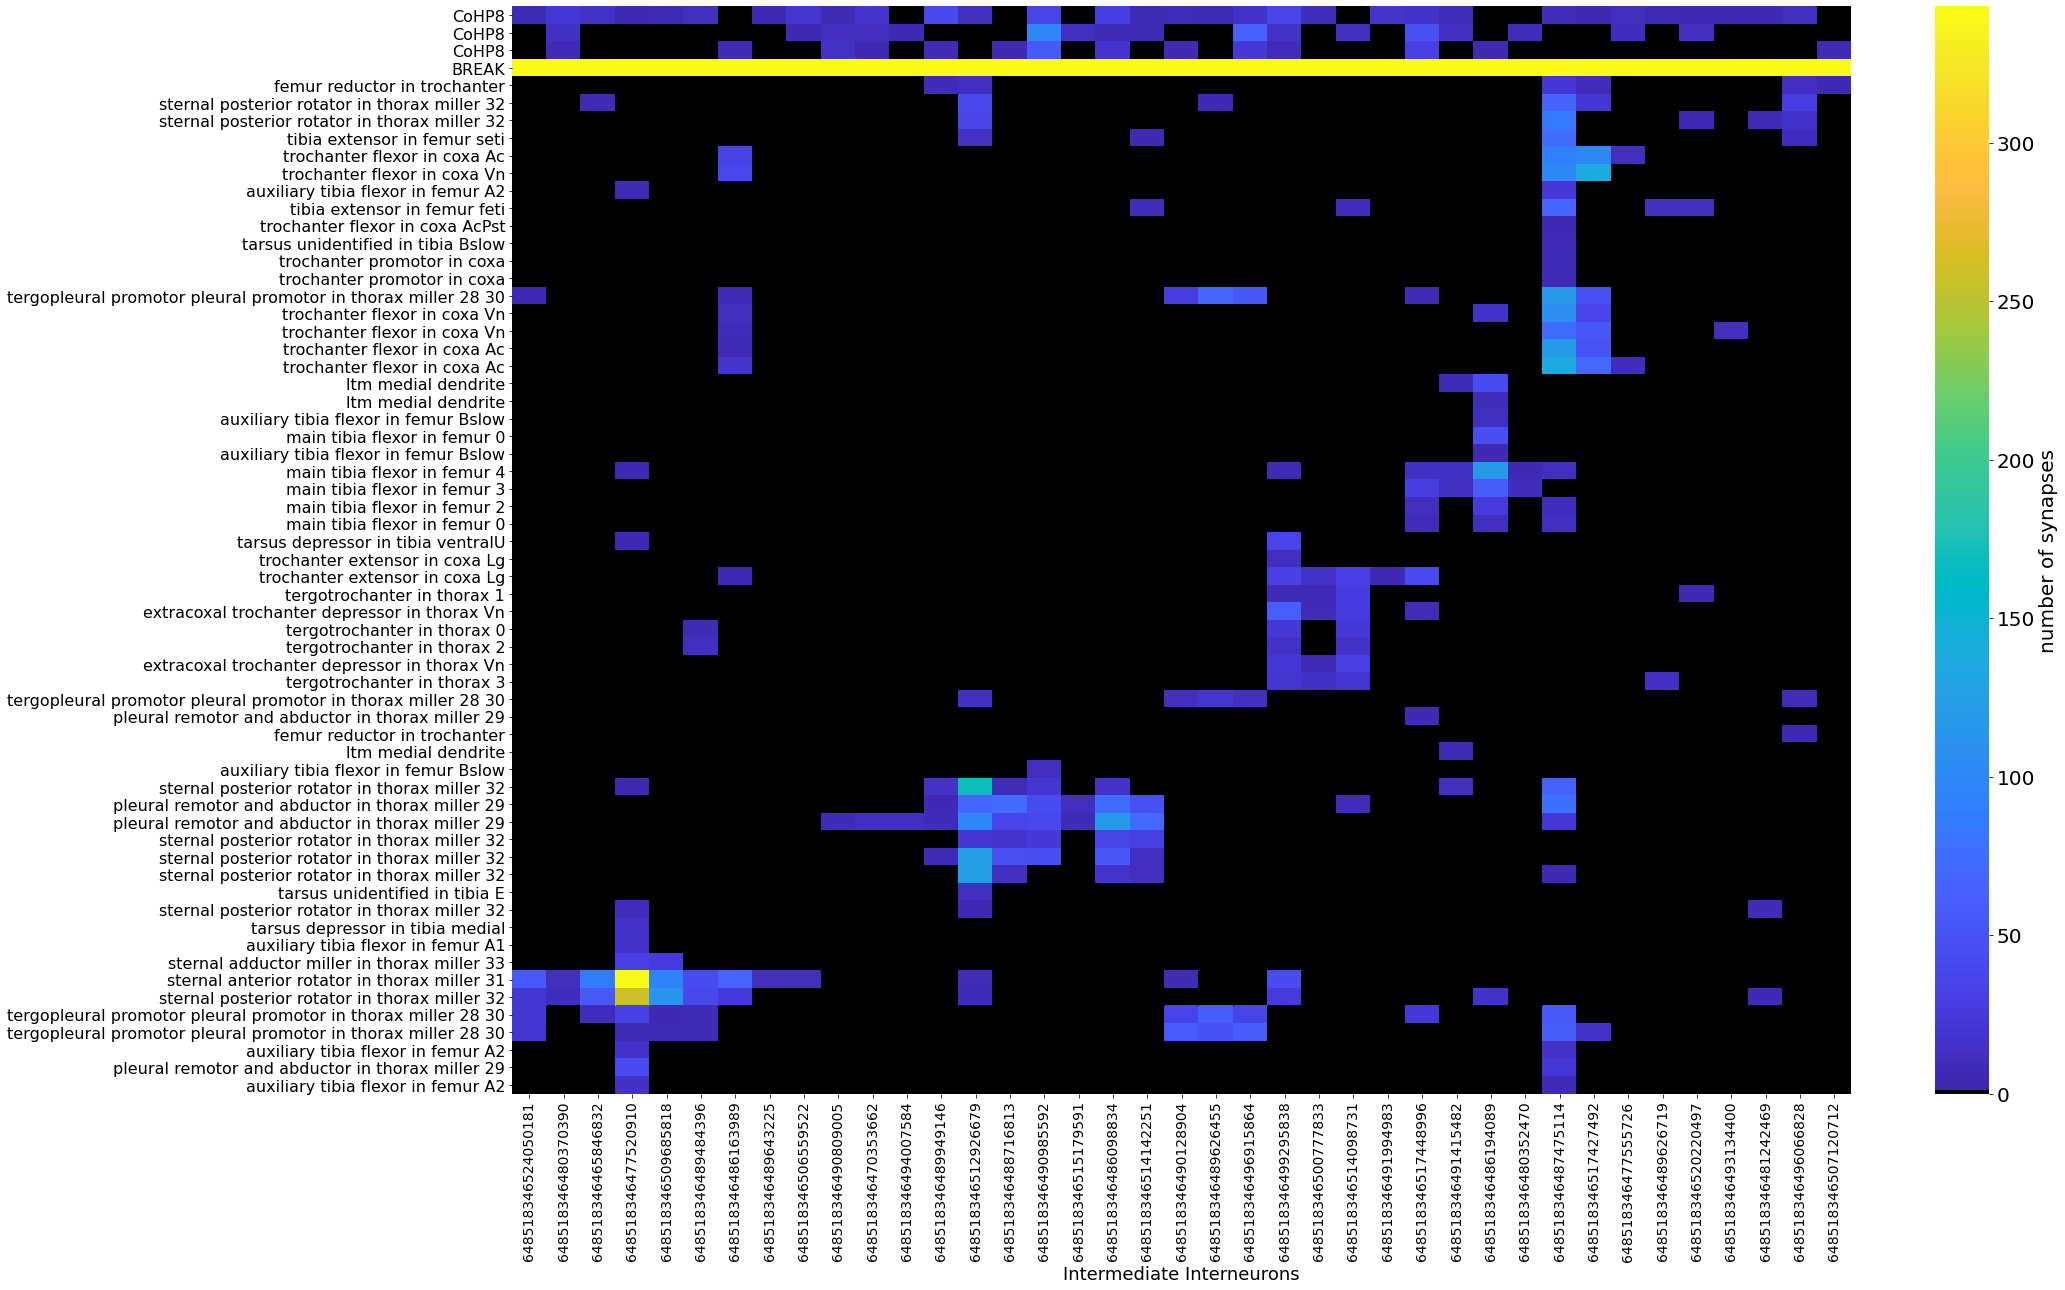

In [55]:
# visualize connectivity matrices 
save_path = 'C:/Users/pratt/Desktop/Neuron_Morphology/EM_Analysis/cohp8_interneuron_mn_connectivity.png'
x_axis_label = 'Intermediate Interneurons'
y_axis_label = 'Hair Plate Neurons'
figure_size = [30,20]
ytick_fontsize = 16
xtick_fontsize = 14
# Prune matrix to include only those motor neurons that recieve input from hair plates
remaining_labels = []
full_interneuron_labels = []
temp_mat =[]
mn_temp_mat = []
for j in range(hp_int_connectivity_mat.shape[1]):
    if np.sum(hp_int_connectivity_mat[:,j]) != 0:
        remaining_labels.append(int_type[j])
        full_interneuron_labels.append(int_segid[j])
        temp_mat.append(hp_int_connectivity_mat[:,j])
        mn_temp_mat.append(mn_int_connectivity_mat[:,j])

if len(remaining_labels) == 0:
    print('no connectivity')
    stop_clause = 0
else:
    stop_clause = 1

if stop_clause == 1:  
    prunned_mat = np.zeros((len(temp_mat[0]), len(temp_mat)))
    mn_prunned_mat = np.zeros((len(mn_temp_mat[0]), len(mn_temp_mat)))
    for i in range(len(temp_mat)):
        prunned_mat[:,i] = temp_mat[i] 
        mn_prunned_mat[:,i] = mn_temp_mat[i]

    # cosine similarity on cell type 1
    sim_mat_1 = cosine_similarity(prunned_mat)
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat_1)
    clustered_order_1 = plot_dendrogram(model, truncate_mode="level", p=hp_int_connectivity_mat.shape[0]) # p truncate mode
    clustered_order_1 = np.array(clustered_order_1).astype(int) # convert strins into integers

    # reorder hairplate and motor neuron matrix
#     reorder_mat = prunned_mat
    reorder_mat = prunned_mat[clustered_order_1, :]

    # Cosine similarity on cell type 2
    sim_mat_2 = cosine_similarity(np.transpose(prunned_mat))

    # setting distance_threshold=0 ensures we compute the full tree.
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat_2)
    clustered_order_2 = plot_dendrogram(model, truncate_mode="level", p=hp_int_connectivity_mat.shape[1]) # p truncate mode
    clustered_order_2 = np.array(clustered_order_2).astype(int) # convert strins into integers

    # reorder hairplate and motor neuron matrix
    reordered_mat_2 = reorder_mat[:, clustered_order_2]
    
    # adjust ticks
    interneurons_reorders = np.array(remaining_labels)[clustered_order_2].tolist()
    full_interneuron_reordered = np.array(full_interneuron_labels)[clustered_order_2].tolist()
    hp_reordered = np.array(hp_type)[clustered_order_1].tolist()
    
# repreat but for the connectivity between these interneurons and motor neurons
# cosine similarity on cell type 1
sim_mat_1 = cosine_similarity(mn_prunned_mat)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat_1)
clustered_order_1 = plot_dendrogram(model, truncate_mode="level", p=mn_int_connectivity_mat.shape[0]) # p truncate mode
clustered_order_1 = np.array(clustered_order_1).astype(int) # convert strins into integers

# reorder hairplate and motor neuron matrix
#     reorder_mat = prunned_mat
mn_reorder_mat = mn_prunned_mat[clustered_order_1, :]
mns_reordered = np.array(mn_type)[clustered_order_1].tolist()

# combine the hp-interneuron and interneuron-mns
combined_mat = np.vstack((reordered_mat_2, np.max(np.vstack((reordered_mat_2, mn_reorder_mat)))*np.ones(reordered_mat_2.shape[1]), mn_reorder_mat))
combined_labels = np.hstack((np.array(hp_reordered),np.array(['BREAK']),np.array(mns_reordered))).tolist()

# final reordering based on interneuron and motor neuron connectivity (V1)
# sim_mat_2 = cosine_similarity(np.transpose(combined_mat)) # v3
sim_mat_2 = cosine_similarity(np.transpose(mn_prunned_mat))

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat_2)
clustered_order_2_mns = plot_dendrogram(model, truncate_mode="level", p=hp_int_connectivity_mat.shape[1]) # p truncate mode
clustered_order_2_mns = np.array(clustered_order_2_mns).astype(int) # convert strins into integers

interneurons_reorders = np.array(interneurons_reorders)[clustered_order_2_mns].tolist()
combined_mat = combined_mat[:,clustered_order_2_mns] # reorder along x dim - interneurons


# visualize prunned matrix
fig = plt.figure(1, figsize = figure_size)
ax = sea.heatmap(combined_mat, xticklabels=interneurons_reorders, yticklabels=combined_labels, cmap=parula_map)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'number of synapses', size=figure_size[1])
plt.xlabel(x_axis_label, fontsize =18)
# plt.ylabel(y_axis_label, fontsize =18)
plt.yticks(fontsize = ytick_fontsize)
plt.xticks(fontsize = xtick_fontsize,rotation = 90)
plt.show()
fig.savefig(save_path, dpi = 200, bbox_inches = 'tight')



In [56]:
interneurons_reorders

['648518346524050181',
 '648518346480370390',
 '648518346465846832',
 '648518346477520910',
 '648518346509685818',
 '648518346489484396',
 '648518346486163989',
 '648518346489643225',
 '648518346506559522',
 '648518346490809005',
 '648518346470353662',
 '648518346494007584',
 '648518346489949146',
 '648518346512926679',
 '648518346488716813',
 '648518346490985592',
 '648518346515179591',
 '648518346486098834',
 '648518346514142251',
 '648518346490128904',
 '648518346489626455',
 '648518346496915864',
 '648518346499295838',
 '648518346500777833',
 '648518346514098731',
 '648518346491994983',
 '648518346517448996',
 '648518346491415482',
 '648518346486194089',
 '648518346480352470',
 '648518346487475114',
 '648518346517427492',
 '648518346477555726',
 '648518346489626719',
 '648518346520220497',
 '648518346493134400',
 '648518346481242469',
 '648518346496066828',
 '648518346507120712']

In [43]:
combined_mat.shape

(81, 113)

In [51]:
# save interneuron segid to csv
d = {'interneuron segid': full_interneuron_reordered}  
       
df = pd.DataFrame(d) 
    
# saving the dataframe 
# df.to_csv('C:/Users/pratt/Desktop/Neuron_Morphology/EM_Analysis/hp_interneuron_mn_connectivity_segid.csv')

In [52]:
np.savetxt('C:/Users/pratt/Desktop/Neuron_Morphology/EM_Analysis/hp_interneuron_mn_connectivity_segid_v3.txt', df.values, fmt='%d')

## Hair-plate input on hemilineage classified interneurons

In [80]:
def create_ordered_connectivity_hm_matrix(cell_type_1_table, cell_type_1_labels, cell_type_2_seg_ids, cell_type_2_labels, x_axis_label, y_axis_label, figure_size, ytick_fontsize, xtick_fontsize, save_path):
    # hair plate and motor neuron connectivity matrix
    connectivity_mat = np.zeros((len(cell_type_1_table), len(cell_type_2_seg_ids)))
    for j in range(len(cell_type_1_table)):
        for i in range(len(cell_type_2_seg_ids)):
            if cell_type_2_seg_ids[i] in cell_type_1_table[j]['post_pt_root_id'].values:
                connectivity_mat[j, i] = cell_type_1_table[j]['number_of_synapses'][cell_type_1_table[j]['post_pt_root_id']==cell_type_2_seg_ids[i]].values


    # Prune matrix to include only those motor neurons that recieve input from hair plates
    prunned_labels = []
    remaining_labels = []
    temp_mat =[]
    for j in range(len(cell_type_2_seg_ids)):
        if np.sum(connectivity_mat[:,j]) == 0:
            prunned_labels.append(cell_type_2_seg_ids[j])
        else:
            remaining_labels.append(cell_type_2_labels[j])
            temp_mat.append(connectivity_mat[:,j])

    if len(remaining_labels) == 0:
        print('no connectivity')
        stop_clause = 0
    else:
        stop_clause = 1

    if stop_clause == 1:  
        prunned_mat = np.zeros((len(temp_mat[0]), len(temp_mat)))
        for i in range(len(temp_mat)):
            prunned_mat[:,i] = temp_mat[i] 

        # cosine similarity on cell type 1
        sim_mat_1 = cosine_similarity(prunned_mat)
        model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat_1)
        clustered_order_1 = plot_dendrogram(model, truncate_mode="level", p=len(cell_type_1_table)) # p truncate mode
        clustered_order_1 = np.array(clustered_order_1).astype(int) # convert strins into integers

        # reorder hairplate and motor neuron matrix
        reorder_mat = prunned_mat[clustered_order_1, :]

        # Cosine similarity on cell type 2
        sim_mat_2 = cosine_similarity(np.transpose(prunned_mat))

        # setting distance_threshold=0 ensures we compute the full tree.
        model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat_2)
        clustered_order_2 = plot_dendrogram(model, truncate_mode="level", p=len(cell_type_2_seg_ids)) # p truncate mode
        clustered_order_2 = np.array(clustered_order_2).astype(int) # convert strins into integers

        # reorder hairplate and motor neuron matrix
        reordered_mat_2 = reorder_mat[:, clustered_order_2]

        # visualize prunned matrix
        fig = plt.figure(1, figsize = figure_size)
        print(np.array(remaining_labels)[clustered_order_2].tolist())
        ax = sea.heatmap(reordered_mat_2, xticklabels=np.array(remaining_labels)[clustered_order_2].tolist(), yticklabels=np.array(cell_type_1_labels)[clustered_order_1].tolist(), cmap=parula_map)
        cbar = ax.collections[0].colorbar
        # here set the labelsize by 20
        cbar.ax.tick_params(labelsize=20)
        cbar.set_label(label = 'number of synapses', size=figure_size[1])
        plt.xlabel(x_axis_label, fontsize =18)
        plt.ylabel(y_axis_label, fontsize =18)
        plt.yticks(fontsize = ytick_fontsize)
        plt.xticks(fontsize = xtick_fontsize,rotation = 90)
        plt.show()
        fig.savefig(save_path, dpi = 200, bbox_inches = 'tight')


In [83]:
hm_name_ids = hm_table['cell_type'].values+ ' - ' + hm_table['pt_root_id'].astype(str).tolist()

In [ ]:
hm_ids 
hm_name
L_hps_ids

In [ ]:
# downstream neurons from hair-plate neurons - ONLY HAIR_PLATES IN T1L
post_synapse_df = client.materialize.synapse_query(pre_ids = L_hps_ids) 
# post_synapse_df = client.materialize.synapse_query(pre_ids = hair_plate_neurons) 
hp_df_store =[]
# for hp_id in hair_plate_neurons:
for hp_id in L_hps_ids:
    # hair plate specific data frame sorted by the strongest synapse
    hp_post_df = post_synapse_df[post_synapse_df['pre_pt_root_id'] == hp_id]
    hp_post_synapses = hp_post_df.groupby(['pre_pt_root_id','post_pt_root_id'])['post_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)
    
    # append this dataframe
    hp_df_store.append(hp_post_synapses)

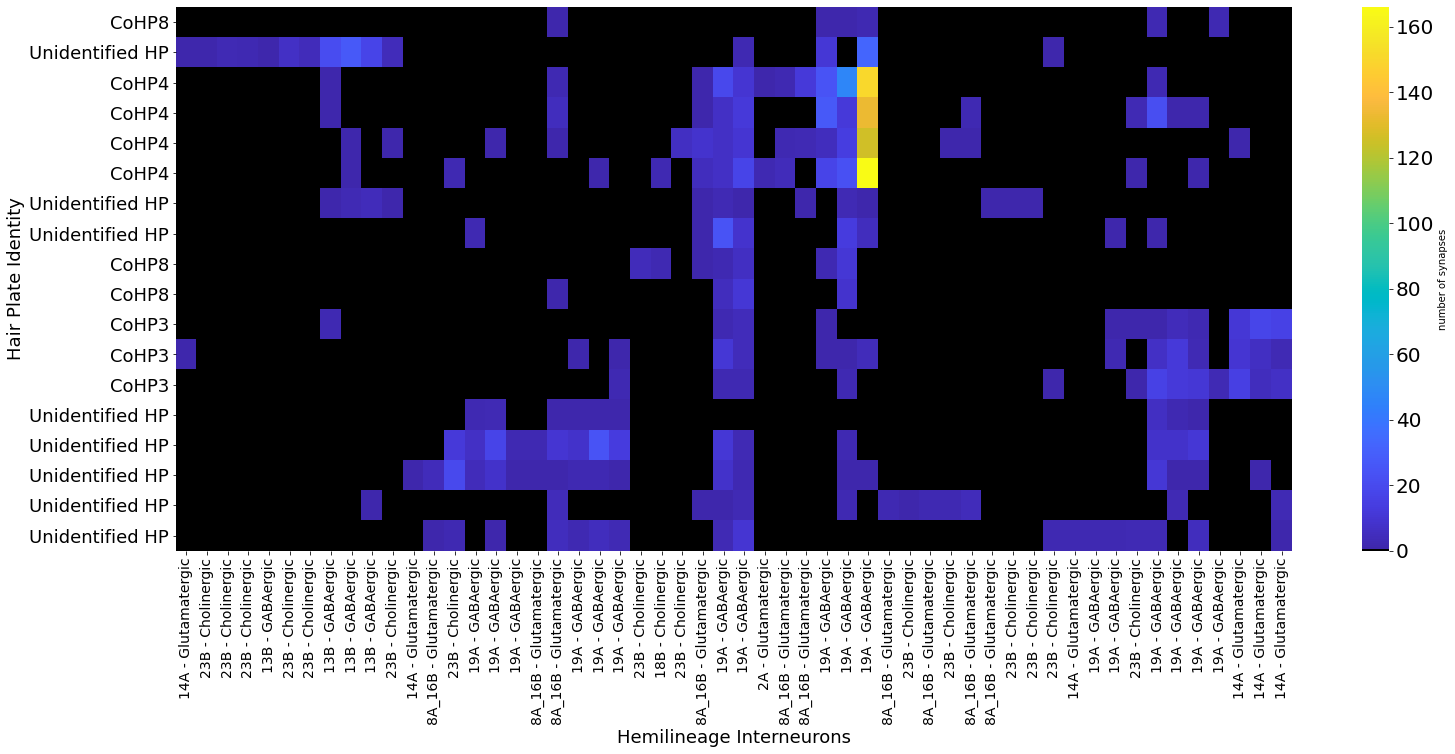

In [74]:
save_path = 'C:/Users/pratt/Desktop/Neuron_Morphology/EM_Analysis/hp_hm__connectivity.png'
x_axis_label = 'Hemilineage Interneurons'
y_axis_label = 'Hair Plate Identity'
figure_size = [25,10]
ytick_fontsize = 18
xtick_fontsize = 14
create_ordered_connectivity_matrix(hp_df_store, L_hps_name, hm_ids, hm_name, x_axis_label, y_axis_label, 
                                   figure_size, ytick_fontsize, xtick_fontsize, save_path)

['14A - 648518346470375422', '23B - 648518346477676439', '23B - 648518346502418246', '23B - 648518346496080396', '13B - 648518346482890726', '23B - 648518346486495153', '23B - 648518346498393364', '13B - 648518346489596797', '13B - 648518346494207602', '13B - 648518346494043639', '23B - 648518346496793316', '14A - 648518346491570088', '8A_16B - 648518346496727341', '23B - 648518346480916224', '19A - 648518346487360403', '19A - 648518346497594870', '19A - 648518346502387879', '8A_16B - 648518346472396747', '8A_16B - 648518346514371271', '19A - 648518346514108715', '19A - 648518346464986229', '19A - 648518346498463984', '23B - 648518346504419052', '18B - 648518346489641303', '23B - 648518346501176205', '8A_16B - 648518346475842018', '19A - 648518346493703928', '19A - 648518346479391451', '2A - 648518346495651691', '8A_16B - 648518346500661427', '8A_16B - 648518346524065029', '19A - 648518346494653091', '19A - 648518346483176612', '19A - 648518346490199048', '8A_16B - 648518346490121224',

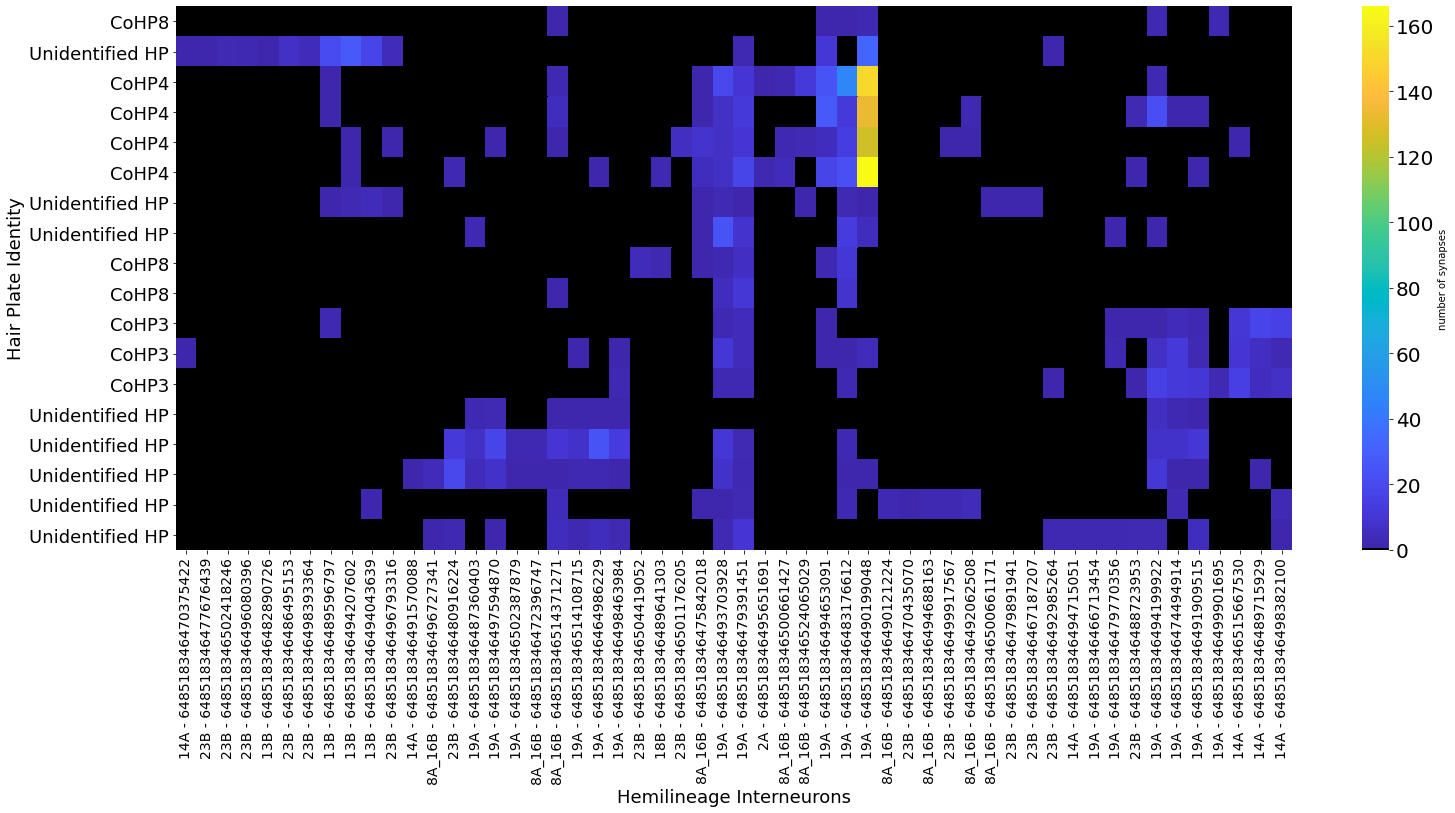

In [84]:
save_path = 'C:/Users/pratt/Desktop/Neuron_Morphology/EM_Analysis/hp_hm__connectivity_ids.png'
x_axis_label = 'Hemilineage Interneurons'
y_axis_label = 'Hair Plate Identity'
figure_size = [25,10]
ytick_fontsize = 18
xtick_fontsize = 14
create_ordered_connectivity_hm_matrix(hp_df_store, L_hps_name, hm_ids, hm_name_ids, x_axis_label, y_axis_label, 
                                   figure_size, ytick_fontsize, xtick_fontsize, save_path)

## Interneurons that recieve input from hair-plate neurons and synapse onto AN (Corinna)

In [8]:
# downstream neurons from hair-plate neurons - ONLY HAIR_PLATES IN T1L
syn_threshold = 5 # synapse threshold
hp_interneuron_df = client.materialize.synapse_query(pre_ids = L_hps_ids) 
hp_int_df_store = []

hp_cnt = 0
# for hp_id in hair_plate_neurons:
for hp_id in L_hps_ids:
    # hair plate specific data frame sorted by the strongest synapse
    hp_int_df = hp_interneuron_df[hp_interneuron_df['pre_pt_root_id'] == hp_id]
    hp_int_synapses = hp_int_df.groupby(['pre_pt_root_id','post_pt_root_id'])['post_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)
    filt_hp_int_df = hp_int_synapses[["post_pt_root_id", "number_of_synapses"]][hp_int_synapses['number_of_synapses'] > syn_threshold]
    
    # append this dataframe
    hp_int_df_store.append(filt_hp_int_df)


In [37]:
# load in AN upstream partner information 
an_ids = np.loadtxt("AN_upstream_segids.txt", dtype = 'int64')
an_syn = np.loadtxt("AN_upstream_synapses.txt", dtype = 'int64')
an_type = np.loadtxt("AN_upstream_neuron_type.txt", dtype = 'str')
num_added_anotations = an_syn.shape[0] - an_type.shape[0]
an_type_full = np.concatenate((an_type, np.repeat('unknown', num_added_anotations))).tolist()
an_ids = an_ids.tolist()
an_syn = an_syn.tolist()

In [87]:
# Note can't do all motor neurons or interneurons at once because the table will be limited (too large)
start_cnt = 0
hp_int_an_connectivty_mat = np.zeros((len(hp_int_df_store), len(an_ids)))
an_idx = -1
for i in an_ids:
    an_idx += 1
    for j in range(len(hp_int_df_store)):
        hp_interneuron_ids = hp_int_df_store[j]['post_pt_root_id'].tolist()
        if np.any(np.array(hp_interneuron_ids) == i):
            hp_int_an_connectivty_mat[j,an_idx] = hp_int_df_store[j]['number_of_synapses'][hp_int_df_store[j]['post_pt_root_id'] == i].values[0]
            
# filter matrix to remove interneurons that don't recieve input from motor neurons and synapse onto the AN
int_connectivity = np.sum(hp_int_an_connectivty_mat, axis=0)
syn_idxs = np.where(int_connectivity > 0)[0]

# apply the filter
filt_connectivity_mat = hp_int_an_connectivty_mat[:,syn_idxs]
hp_int_an_ids = np.array(an_ids)[syn_idxs].tolist()
hp_int_an_type = np.array(an_type_full)[syn_idxs].tolist()
hp_int_an_syn = np.array(an_syn)[syn_idxs].tolist()

            

In [105]:
# plot connectivity matrix
# cosine similarity on cell type 1
sim_mat_1 = cosine_similarity(filt_connectivity_mat)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat_1)
clustered_order_1 = plot_dendrogram(model, truncate_mode="level", p=filt_connectivity_mat.shape[0]) # p truncate mode
clustered_order_1 = np.array(clustered_order_1).astype(int) # convert strins into integers

# reorder hairplate and motor neuron matrix
reorder_mat = filt_connectivity_mat[clustered_order_1, :]

# Cosine similarity on cell type 2
sim_mat_2 = cosine_similarity(np.transpose(filt_connectivity_mat))

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat_2)
clustered_order_2 = plot_dendrogram(model, truncate_mode="level", p=filt_connectivity_mat.shape[1]) # p truncate mode
clustered_order_2 = np.array(clustered_order_2).astype(int) # convert strins into integers

# reorder matrix
reordered_mat_2 = reorder_mat[:, clustered_order_2]
reorder_int_ids = np.array(hp_int_an_ids)[clustered_order_2]
reorder_int_type = np.array(hp_int_an_type)[clustered_order_2]
reorder_int_syn = np.array(hp_int_an_syn)[clustered_order_2]

int_full_name = []
for j in range(len(reorder_int_ids)):
    int_full_name.append(reorder_int_type[j] + ' - ' + str(reorder_int_ids[j]))

hp_full_name = []
for j in range(len(L_hps_name)):
    hp_full_name.append(L_hps_name[j] + ' - ' + str(L_hps_ids[j]))
    
hp_full_name = np.array(hp_full_name)[clustered_order_1]
    
# combine matrices
combined_connectivity_mat = np.vstack((reordered_mat_2, np.zeros((2,reordered_mat_2.shape[1])), reorder_int_syn))
combined_labels = np.concatenate((hp_full_name, np.array([' ',' ','AN'])))



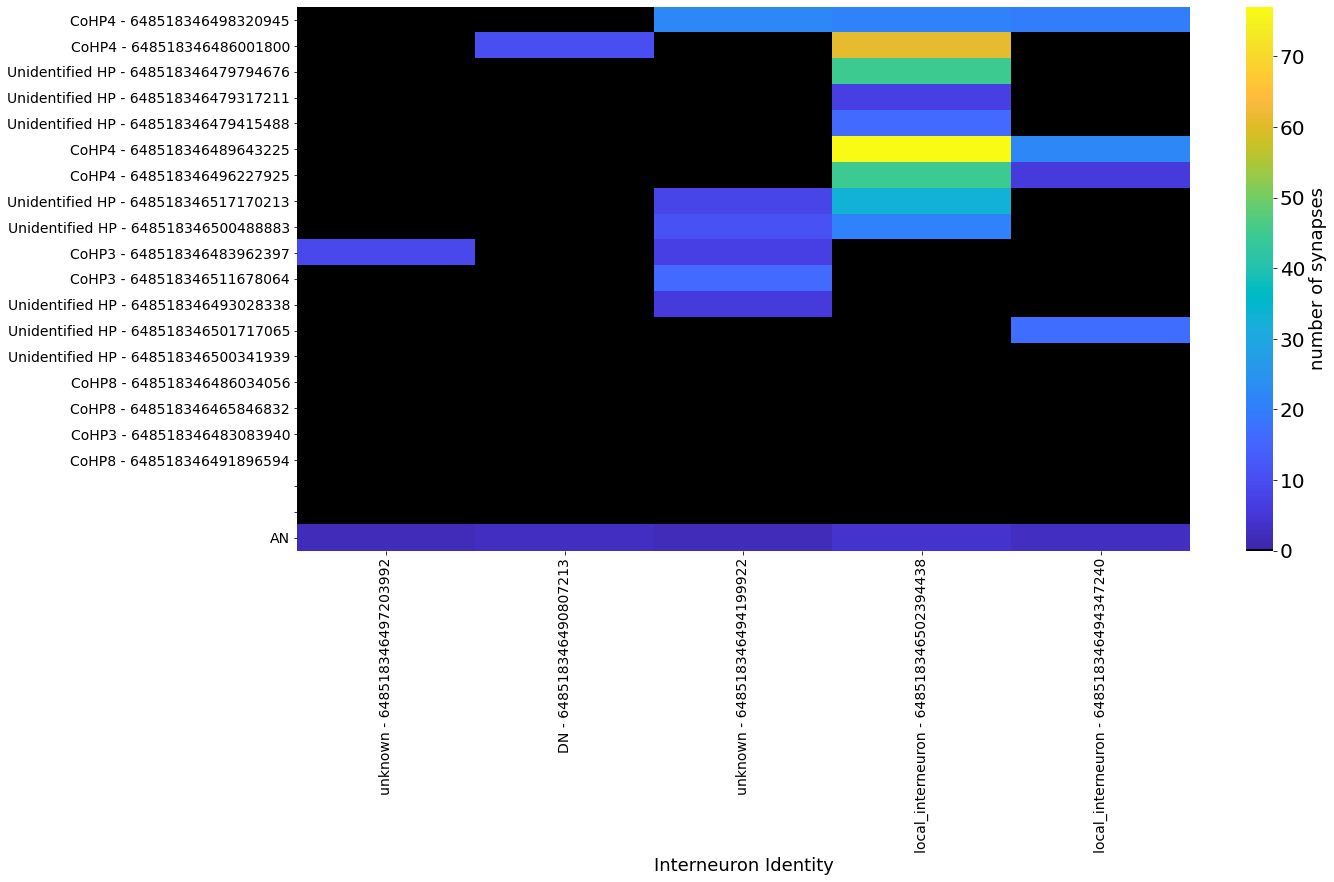

In [111]:
# visualize connectivity matrix
save_path = 'C:/Users/pratt/Desktop/Neuron_Morphology/EM_Analysis/hp_interneuron_an_connectivity.png'
fig = plt.figure(1, figsize = [20, 10])
ax = sea.heatmap(combined_connectivity_mat, xticklabels=int_full_name, yticklabels=combined_labels, cmap=parula_map)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'number of synapses', size=18)
plt.xlabel('Interneuron Identity', fontsize =18)
# plt.ylabel(y_axis_label, fontsize =18)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14,rotation = 90)
plt.show()
fig.savefig(save_path, dpi = 200, bbox_inches = 'tight')

In [96]:
int_full_name

['unknown - 648518346497203992',
 'DN - 648518346490807213',
 'unknown - 648518346494199922',
 'local_interneuron - 648518346502394438',
 'local_interneuron - 648518346494347240']

In [112]:
reorder_int_syn

array([2, 3, 2, 4, 3])

### Hair-plate neurons onto hair-plate neurons

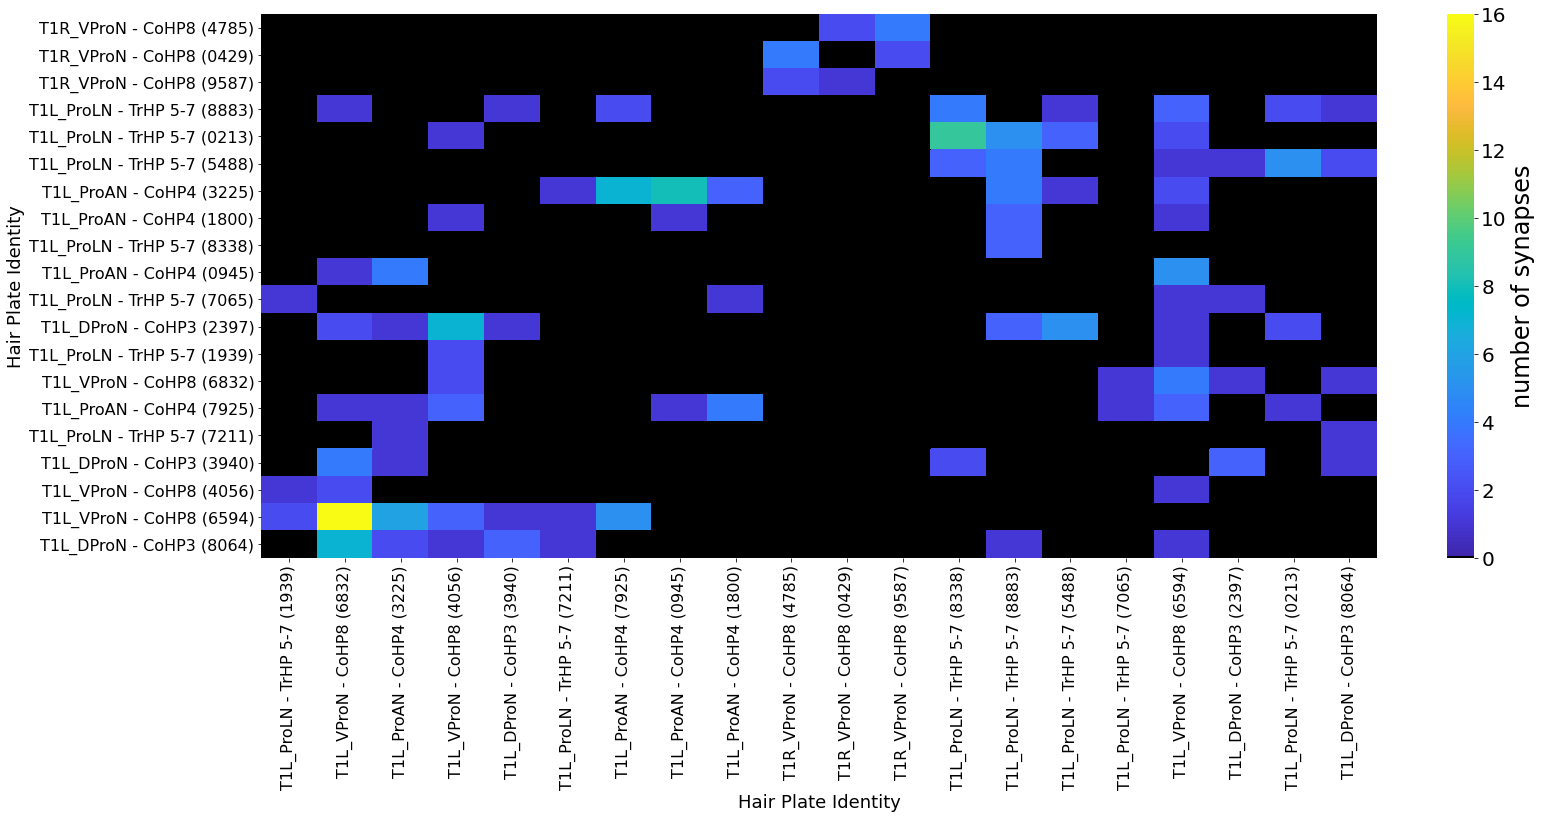

In [210]:
save_path = 'C:/Users/pratt/Desktop/tuthill_lab/conferences/Neuronal Circuits 2022/hp_mn_connectivity.pdf'
x_axis_label = 'Hair Plate Identity'
y_axis_label = 'Hair Plate Identity'
figure_size = [25,10]
ytick_fontsize = 16
xtick_fontsize = 16
create_ordered_connectivity_matrix(hp_df_store, hair_plate_identity, hair_plate_neurons, hair_plate_identity, x_axis_label, y_axis_label, 
                                   figure_size, ytick_fontsize, xtick_fontsize)

### Hair-plate neurons onto 19 Ab interneurons

In [152]:
interneuron_19Ab_seg_id = [648518346474494914,648518346515170631,648518346493703928,648518346483175588,648518346487360403,648518346479192977,648518346500411352,648518346464986229,648518346504011560,648518346499901695,648518346514108715,648518346490143240,648518346479770356,648518346494653091,648518346502387879,648518346483668655,648518346477641623,648518346497594870,648518346483176612]
interneuron_19Ab_label = []
for j in range(len(interneuron_19Ab_seg_id)):
    interneuron_19Ab_label.append('19Ab - ' + np.array(interneuron_19Ab_seg_id).astype('str')[j][-4::])

In [123]:
expand_name_L = []
for j in range(len(L_id)):
    expand_name_L.append(L_id[j] + ' ' + str(L_19A[j])[-4::])
    

In [77]:
L_19A = [648518346500411352, 648518346493703928, 648518346487360403, 648518346483175588, 648518346479192977, 
         648518346497594870,648518346514108715, 648518346464986229, 648518346474494914, 648518346483668655, 
         648518346504011560, 648518346483176612]
L_id = np.repeat(np.array(['19Ab Left']), len(L_19A)).tolist()
R_19A = [648518346479770356, 648518346494653091, 648518346490143240, 648518346499901695, 648518346502387879,
         648518346477641623, 648518346515170631]
R_id = np.repeat(np.array(['19Ab Right']), len(R_19A)).tolist()
combined_19A_ids = L_19A + R_19A
combined_19A_names = L_id + R_id
combined_hp_19A_ids = L_hps_ids + combined_19A_ids
combined_hp_19A_names = L_hps_name  + combined_19A_names

In [143]:
L_hps_name

['CoHP3',
 'CoHP3',
 'CoHP3',
 'CoHP4',
 'CoHP4',
 'CoHP4',
 'CoHP4',
 'CoHP8',
 'CoHP8',
 'CoHP8',
 'Unidentified HP',
 'Unidentified HP',
 'Unidentified HP',
 'Unidentified HP',
 'Unidentified HP',
 'Unidentified HP',
 'Unidentified HP']

In [145]:
R_hps_ids

array([648518346484630429, 648518346509299587, 648518346497094785,
       648518346517204840, 648518346497094785], dtype=int64)

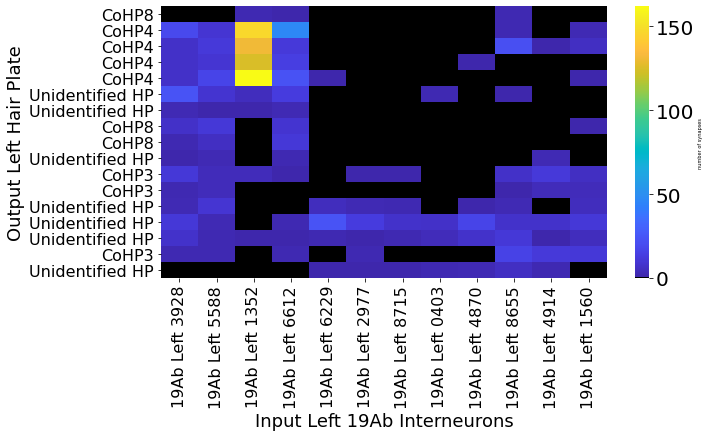

In [125]:
save_path = 'C:/Users/pratt/Desktop/tuthill_lab/conferences/Neuronal Circuits 2022/Lhp_onto_L19Ab_connectivity.pdf'
x_axis_label = 'Input Left 19Ab Interneurons'
y_axis_label = 'Output Left Hair Plate'
figure_size = [10,5]
ytick_fontsize = 16
xtick_fontsize = 16
create_ordered_connectivity_matrix(hp_df_store, L_hps_name, L_19A, expand_name_L, x_axis_label, y_axis_label, 
                                   figure_size, ytick_fontsize, xtick_fontsize, save_path)

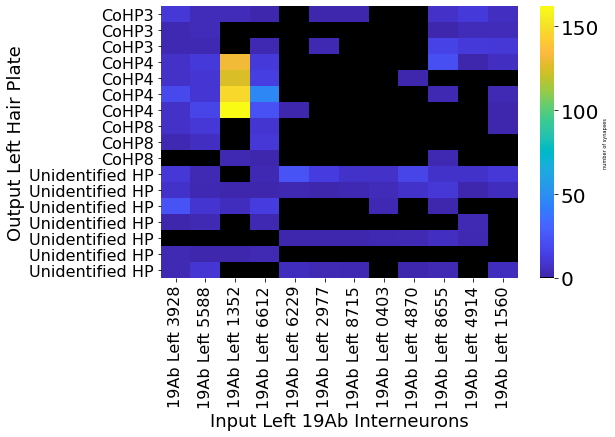

In [141]:
# keep hair-plate output the same, but cluster on output
cell_type_1_table = hp_df_store
cell_type_1_labels = L_hps_name
cell_type_2_seg_ids = L_19A
cell_type_2_labels = expand_name_L
save_path = 'C:/Users/pratt/Desktop/tuthill_lab/conferences/Neuronal Circuits 2022/Lhp_onto_L19Ab_connectivity.pdf'
x_axis_label = 'Input Left 19Ab Interneurons'
y_axis_label = 'Output Left Hair Plate'
figure_size = [8,5]
ytick_fontsize = 16
xtick_fontsize = 16
connectivity_mat = np.zeros((len(cell_type_1_table), len(cell_type_2_seg_ids)))
for j in range(len(cell_type_1_table)):
    for i in range(len(cell_type_2_seg_ids)):
        if cell_type_2_seg_ids[i] in cell_type_1_table[j]['post_pt_root_id'].values:
            connectivity_mat[j, i] = cell_type_1_table[j]['number_of_synapses'][cell_type_1_table[j]['post_pt_root_id']==cell_type_2_seg_ids[i]].values


# Prune matrix to include only those motor neurons that recieve input from hair plates
prunned_labels = []
remaining_labels = []
temp_mat =[]
for j in range(len(cell_type_2_seg_ids)):
    if np.sum(connectivity_mat[:,j]) == 0:
        prunned_labels.append(cell_type_2_seg_ids[j])
    else:
        remaining_labels.append(cell_type_2_labels[j])
        temp_mat.append(connectivity_mat[:,j])

if len(remaining_labels) == 0:
    print('no connectivity')
    stop_clause = 0
else:
    stop_clause = 1

if stop_clause == 1:  
    prunned_mat = np.zeros((len(temp_mat[0]), len(temp_mat)))
    for i in range(len(temp_mat)):
        prunned_mat[:,i] = temp_mat[i] 

#     # cosine similarity on cell type 1
#     sim_mat_1 = cosine_similarity(prunned_mat)
#     model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat_1)
#     clustered_order_1 = plot_dendrogram(model, truncate_mode="level", p=len(cell_type_1_table)) # p truncate mode
#     clustered_order_1 = np.array(clustered_order_1).astype(int) # convert strins into integers

    # reorder hairplate and motor neuron matrix
    reorder_mat = prunned_mat
#     reorder_mat = prunned_mat[clustered_order_1, :]

    # Cosine similarity on cell type 2
    sim_mat_2 = cosine_similarity(np.transpose(prunned_mat))

    # setting distance_threshold=0 ensures we compute the full tree.
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat_2)
    clustered_order_2 = plot_dendrogram(model, truncate_mode="level", p=len(cell_type_2_seg_ids)) # p truncate mode
    clustered_order_2 = np.array(clustered_order_2).astype(int) # convert strins into integers

    # reorder hairplate and motor neuron matrix
    reordered_mat_2 = reorder_mat[:, clustered_order_2]

    # visualize prunned matrix
    fig = plt.figure(1, figsize = figure_size)
    ax = sea.heatmap(reordered_mat_2, xticklabels=np.array(remaining_labels)[clustered_order_2].tolist(), yticklabels=cell_type_1_labels, cmap=parula_map)
    cbar = ax.collections[0].colorbar
    # here set the labelsize by 20
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(label = 'number of synapses', size=figure_size[1])
    plt.xlabel(x_axis_label, fontsize =18)
    plt.ylabel(y_axis_label, fontsize =18)
    plt.yticks(fontsize = ytick_fontsize)
    plt.xticks(fontsize = xtick_fontsize,rotation = 90)
    plt.show()
    fig.savefig(save_path, dpi = 200, bbox_inches = 'tight')

### 19Ab input onto hair-plate neurons

In [111]:
# downstream neurons from hair-plate neurons
post_synapse_df = client.materialize.synapse_query(pre_ids = L_19A) 
df_store =[]
for j in L_19A:
    # hair plate specific data frame sorted by the strongest synapse
    post_df = post_synapse_df[post_synapse_df['pre_pt_root_id'] == j]
    post_synapses = post_df.groupby(['pre_pt_root_id','post_pt_root_id'])['post_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)
    
    # append this dataframe
    df_store.append(post_synapses)

In [149]:
reordered_mat_2

array([[ 0.,  4.,  0.,  0.],
       [ 0.,  2.,  0.,  0.],
       [ 0.,  3.,  1.,  0.],
       [ 0.,  2.,  1.,  0.],
       [ 0.,  8., 10.,  6.],
       [ 0.,  0.,  1.,  1.],
       [ 0.,  3., 11.,  2.],
       [ 2.,  4., 14., 12.],
       [ 0.,  5., 12., 10.]])

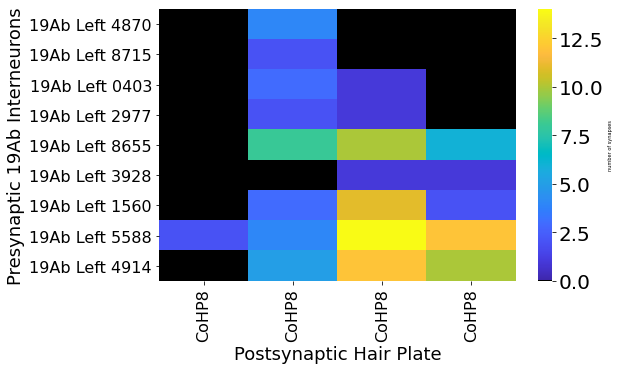

In [147]:
cell_type_1_table = df_store
cell_type_1_labels = expand_name_L
cell_type_2_seg_ids = R_hps_ids
cell_type_2_labels = R_hps_name
save_path = 'C:/Users/pratt/Desktop/tuthill_lab/conferences/Neuronal Circuits 2022/T1L_19A_onto_t1r_hps.pdf'
x_axis_label = 'Postsynaptic Hair Plate'
y_axis_label = 'Presynaptic 19Ab Interneurons'
figure_size = [8,5]
ytick_fontsize = 16
xtick_fontsize = 16

# hair plate and motor neuron connectivity matrix
connectivity_mat = np.zeros((len(cell_type_1_table), len(cell_type_2_seg_ids)))
for j in range(len(cell_type_1_table)):
    for i in range(len(cell_type_2_seg_ids)):
        if cell_type_2_seg_ids[i] in cell_type_1_table[j]['post_pt_root_id'].values:
            connectivity_mat[j, i] = cell_type_1_table[j]['number_of_synapses'][cell_type_1_table[j]['post_pt_root_id']==cell_type_2_seg_ids[i]].values


# Prune matrix to include only those motor neurons that recieve input from hair plates
prunned_labels = []
remaining_labels = []
temp_mat =[]
for j in range(len(cell_type_2_seg_ids)):
    if np.sum(connectivity_mat[:,j]) == 0:
        prunned_labels.append(cell_type_2_seg_ids[j])
    else:
        remaining_labels.append(cell_type_2_labels[j])
        temp_mat.append(connectivity_mat[:,j])

if len(remaining_labels) == 0:
    print('no connectivity')
    stop_clause = 0
else:
    stop_clause = 1

if stop_clause == 1:  
    prunned_mat = np.zeros((len(temp_mat[0]), len(temp_mat)))
    for i in range(len(temp_mat)):
        prunned_mat[:,i] = temp_mat[i] 

    # cosine similarity on cell type 1
    sim_mat_1 = cosine_similarity(prunned_mat)
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat_1)
    clustered_order_1 = plot_dendrogram(model, truncate_mode="level", p=len(cell_type_1_table)) # p truncate mode
    clustered_order_1 = np.array(clustered_order_1).astype(int) # convert strins into integers

    # reorder hairplate and motor neuron matrix
    reorder_mat = prunned_mat[clustered_order_1, :]

    # Cosine similarity on cell type 2
    sim_mat_2 = cosine_similarity(np.transpose(prunned_mat))

    # setting distance_threshold=0 ensures we compute the full tree.
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat_2)
    clustered_order_2 = plot_dendrogram(model, truncate_mode="level", p=len(cell_type_2_seg_ids)) # p truncate mode
    clustered_order_2 = np.array(clustered_order_2).astype(int) # convert strins into integers

    # reorder hairplate and motor neuron matrix
    reordered_mat_2 = reorder_mat[:, clustered_order_2]
    
    # remove rows with 
    row_vals = np.sum(reordered_mat_2, axis = 1)
    reorder_yticks = np.array(cell_type_1_labels)[clustered_order_1]
    reorder_yticks = reorder_yticks[row_vals>0].tolist()
    reordered_mat_2 = reordered_mat_2[row_vals>0,:]

    # visualize prunned matrix
    fig = plt.figure(1, figsize = figure_size)
    ax = sea.heatmap(reordered_mat_2, xticklabels=np.array(remaining_labels)[clustered_order_2].tolist(), yticklabels=reorder_yticks, cmap=parula_map)
    cbar = ax.collections[0].colorbar
    # here set the labelsize by 20
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(label = 'number of synapses', size=figure_size[1])
    plt.xlabel(x_axis_label, fontsize =18)
    plt.ylabel(y_axis_label, fontsize =18)
    plt.yticks(fontsize = ytick_fontsize)
    plt.xticks(fontsize = xtick_fontsize,rotation = 90)
    plt.show()
    fig.savefig(save_path, dpi = 200, bbox_inches = 'tight')

### Hair-plate neurons onto 23B interneurons

In [171]:
interneuron_23Bb_seg_id = [648518346496226389,648518346513879577,648518346475395968,648518346483108542,648518346486223017,648518346465906480,648518346504375532,648518346520470326,648518346506583586,648518346489922843,648518346499390183,648518346495633259,648518346489471084,648518346477620375,648518346496026380,648518346491450566,648518346501243747,648518346499752915,648518346492755118,648518346517683560,648518346496770532,648518346493955339,648518346477597591,648518346490933624,648518346487968030,648518346491582225,648518346488345071,648518346497774234,648518346509910822,648518346504379884,648518346493699576,648518346475203937,648518346517691496,648518346499396583,648518346500416216,648518346487577579,648518346482780581,648518346517358148,648518346500606899,648518346500415960,648518346494012155]
interneuron_23Bb_label = []
for j in range(len(interneuron_23Bb_seg_id)):
    interneuron_23Bb_label.append('23Bb - ' + np.array(interneuron_23Bb_seg_id).astype('str')[j][-4::])

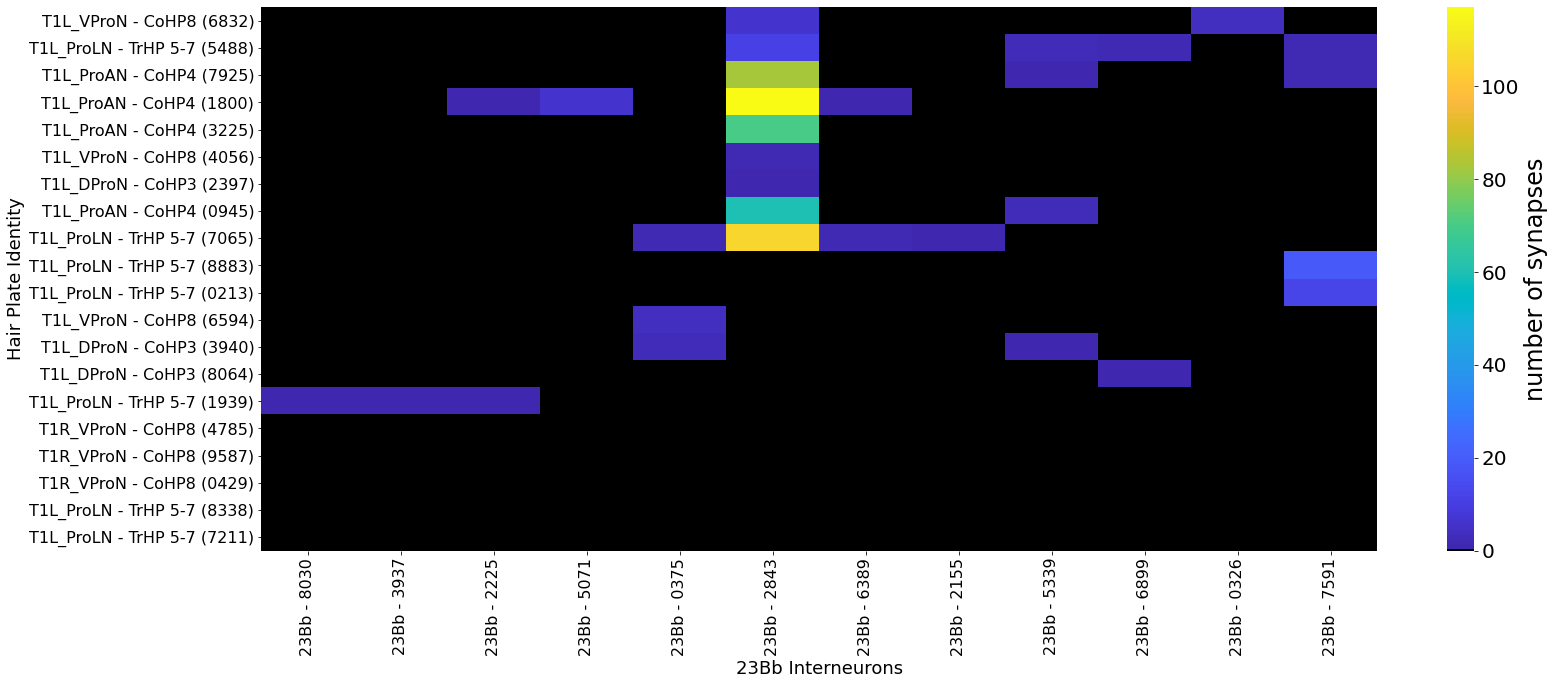

In [213]:
x_axis_label = '23Bb Interneurons'
y_axis_label = 'Hair Plate Identity'
figure_size = [25,10]
ytick_fontsize = 16
xtick_fontsize = 16
create_ordered_connectivity_matrix(hp_df_store, hair_plate_identity, interneuron_23Bb_seg_id, interneuron_23Bb_label, x_axis_label, y_axis_label, 
                                   figure_size, ytick_fontsize, xtick_fontsize)

### Hair-plate neurons onto 13Ba interneurons

In [166]:
interneuron_13Ba_seg_id = [648518346497130113,648518346515626826,648518346482783141,648518346494671349,648518346489596541,648518346491538856]
interneuron_13Ba_label = []
for j in range(len(interneuron_13Ba_seg_id)):
    interneuron_13Ba_label.append('13Ba - ' + np.array(interneuron_13Ba_seg_id).astype('str')[j][-4::])

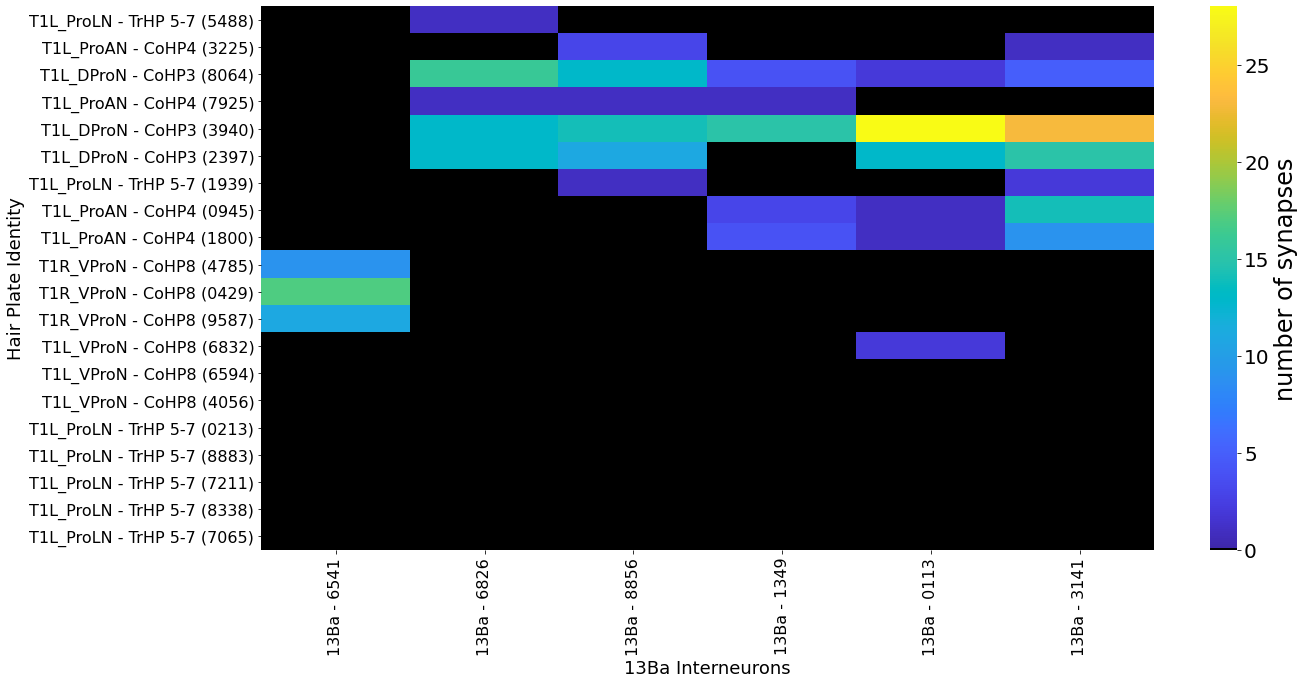

In [214]:
x_axis_label = '13Ba Interneurons'
y_axis_label = 'Hair Plate Identity'
figure_size = [20,10]
ytick_fontsize = 16
xtick_fontsize = 16
create_ordered_connectivity_matrix(hp_df_store, hair_plate_identity, interneuron_13Ba_seg_id, interneuron_13Ba_label, x_axis_label, y_axis_label, 
                                   figure_size, ytick_fontsize, xtick_fontsize)

### Hair-plate neurons onto ascending neurons

In [169]:
an_neuron_segid = [648518346494616565,648518346477721045,648518346514037982,648518346481204367,648518346472411657,648518346497697895,648518346480108859,648518346476895944,648518346494094962,648518346496529410,648518346465747760,648518346491337158,648518346472352265]
an_neuron_label = []
for j in range(len(an_neuron_segid)):
    an_neuron_label.append('AN - ' + np.array(an_neuron_segid).astype('str')[j][-4::])

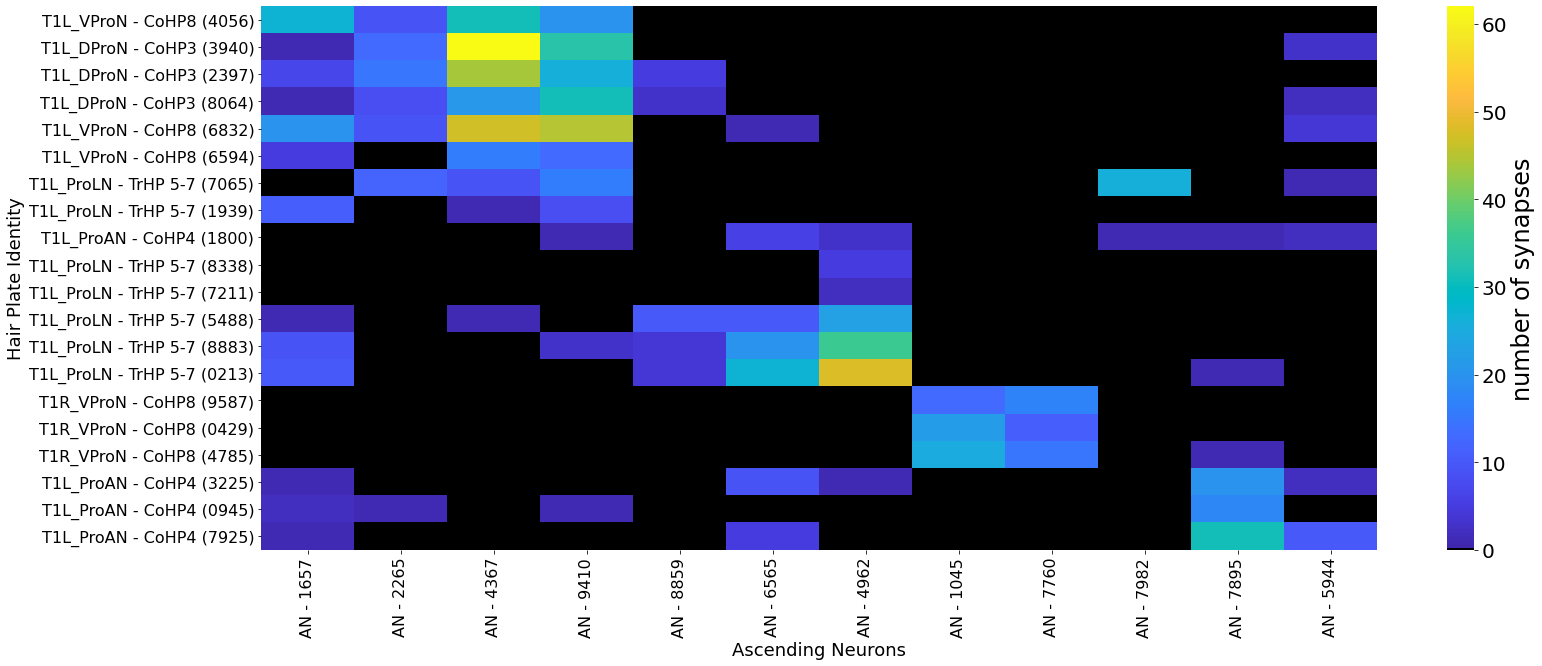

In [215]:
x_axis_label = 'Ascending Neurons'
y_axis_label = 'Hair Plate Identity'
figure_size = [25,10]
ytick_fontsize = 16
xtick_fontsize = 16
create_ordered_connectivity_matrix(hp_df_store, hair_plate_identity, an_neuron_segid, an_neuron_label, x_axis_label, y_axis_label, 
                                   figure_size, ytick_fontsize, xtick_fontsize)

### Hair-plate neurons onto intersegmental neurons

In [176]:
interseg_neuron_segid = [648518346498883905, 648518346481710269, 648518346500351155, 648518346483194788, 648518346489922843,648518346490291292,648518346493694200,648518346493759601,648518346477597591,648518346497969050,648518346520003921,648518346475206968,648518346511868607,648518346476786448,648518346497955994,648518346482791077,648518346524056837,648518346477627287,648518346466956782,648518346478921679,648518346491404218,648518346492256451,648518346500758633,648518346471739035,648518346502302547]
interseg_neuron_label = []
for j in range(len(interseg_neuron_segid)):
    if j < 2:
        interseg_neuron_label.append('20A-22Aa - ' + np.array(interseg_neuron_segid).astype('str')[j][-4::])
    elif j == 2:
        interseg_neuron_label.append('19Bb - ' + np.array(interseg_neuron_segid).astype('str')[j][-4::])
    elif j == 3:
        interseg_neuron_label.append('23Ba - ' + np.array(interseg_neuron_segid).astype('str')[j][-4::])
    elif j == 4:
        interseg_neuron_label.append('23Bb - ' + np.array(interseg_neuron_segid).astype('str')[j][-4::])
    else:
        interseg_neuron_label.append('Intersegmental - ' + np.array(interseg_neuron_segid).astype('str')[j][-4::])

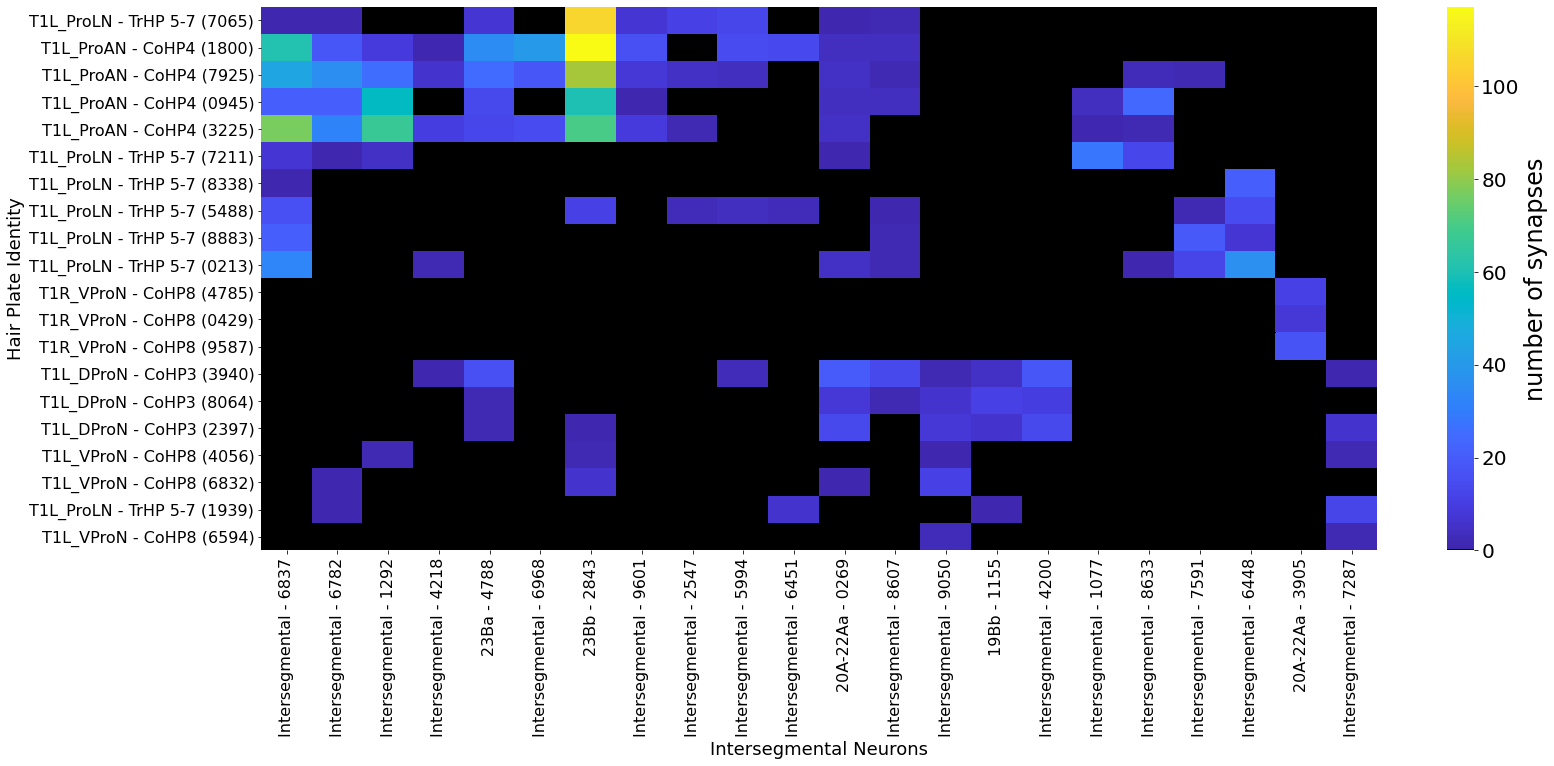

In [216]:
x_axis_label = 'Intersegmental Neurons'
y_axis_label = 'Hair Plate Identity'
figure_size = [25,10]
ytick_fontsize = 16
xtick_fontsize = 16
create_ordered_connectivity_matrix(hp_df_store, hair_plate_identity, interseg_neuron_segid, interseg_neuron_label, x_axis_label, y_axis_label, 
                                   figure_size, ytick_fontsize, xtick_fontsize)

## Connectivity analysis code snipbits

number hairplate and motor neurons (20, 139)
hairplate motor neuron connectivity matrix [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 3. ... 0. 0. 0.]]


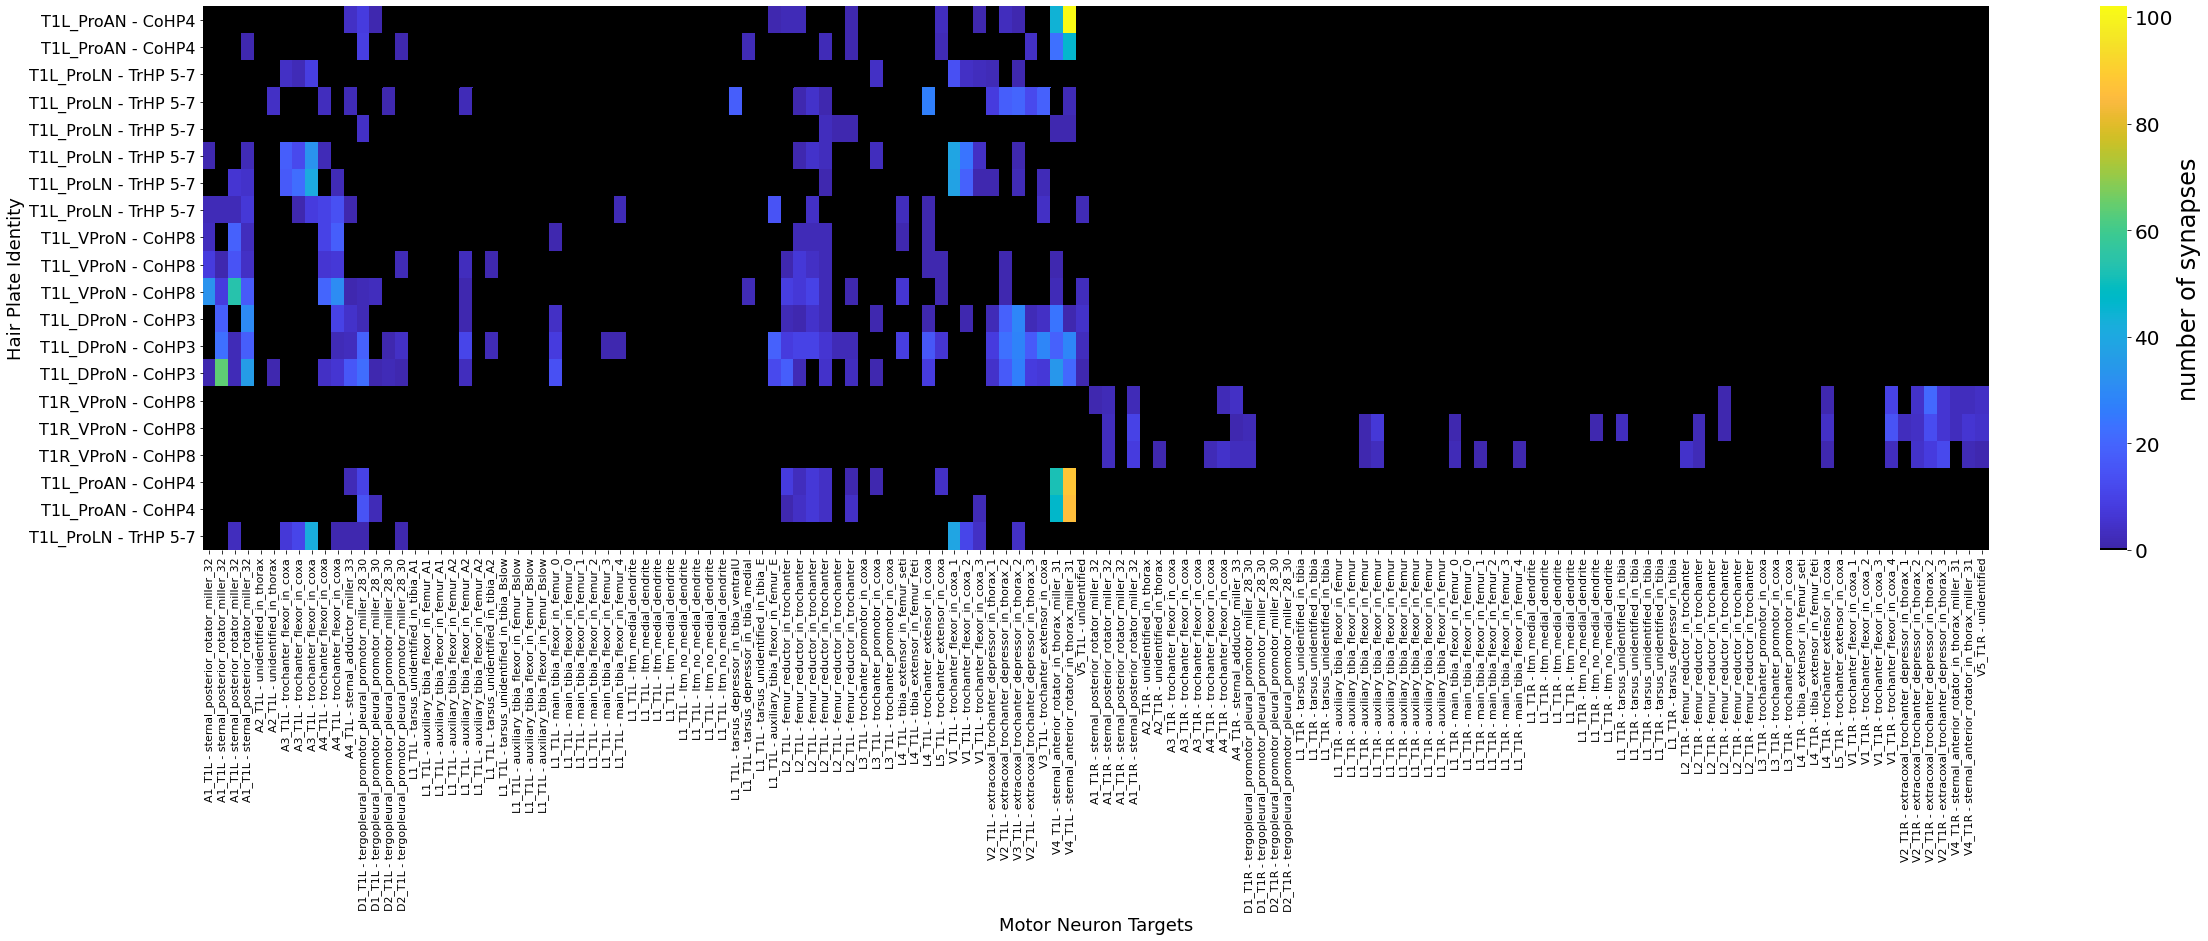

In [50]:
# hair plate and motor neuron connectivity matrix
hp_mn_connectivity_mat = np.zeros((len(hp_df_store), len(mns)))
for hp in range(len(hp_df_store)):
    for mn in range(len(mns)):
        if mns[mn] in hp_df_store[hp]['post_pt_root_id'].values:
            hp_mn_connectivity_mat[hp, mn] = hp_df_store[hp]['number_of_synapses'][hp_df_store[hp]['post_pt_root_id']==mns[mn]].values

# visualize matrix
fig = plt.figure(1, figsize = [40,10])
ax = sea.heatmap(hp_mn_connectivity_mat, xticklabels=mn_identity, yticklabels=hair_plate_identity, cmap=parula_map)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'number of synapses', size=24)
plt.xlabel('Motor Neuron Targets', fontsize =18)
plt.ylabel('Hair Plate Identity', fontsize =18)
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 11)
plt.show()
# fig.savefig('hairplate_motor_neuron_connectivity.png', dpi = 200, bbox_inches = 'tight')


In [57]:
# Prune matrix to include only those motor neurons that recieve input from hair plates
prunned_mn_labels = []
remaining_mn_labels = []
temp_mat =[]
for j in range(len(mns)):
    if np.sum(hp_mn_connectivity_mat[:,j]) == 0:
        prunned_mn_labels.append(mns[j])
    else:
        remaining_mn_labels.append(mn_identity[j])
        temp_mat.append(hp_mn_connectivity_mat[:,j])

prunned_hp_mn_mat = np.zeros((len(temp_mat[0]), len(temp_mat)))
for i in range(len(temp_mat)):
    prunned_hp_mn_mat[:,i] = temp_mat[i]              

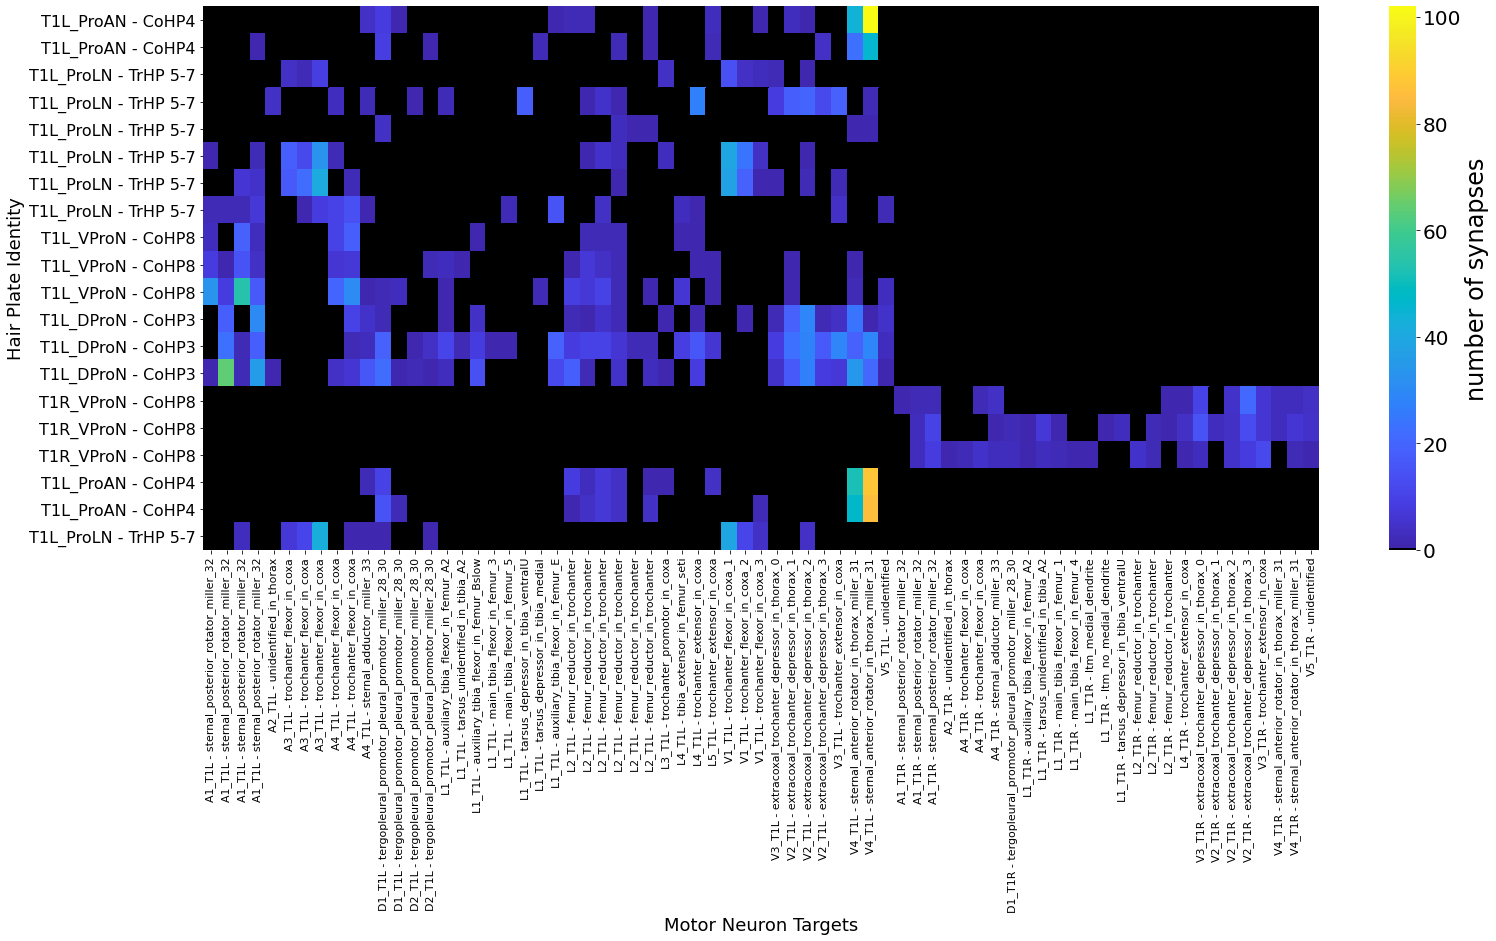

In [64]:
# visualize prunned matrix
fig = plt.figure(1, figsize = [25,10])
ax = sea.heatmap(prunned_hp_mn_mat, xticklabels=remaining_mn_labels, yticklabels=hair_plate_identity, cmap=parula_map)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'number of synapses', size=24)
plt.xlabel('Motor Neuron Targets', fontsize =18)
plt.ylabel('Hair Plate Identity', fontsize =18)
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 11)
plt.show()
# fig.savefig('hairplate_motor_neuron_connectivity.png', dpi = 200, bbox_inches = 'tight')


<AxesSubplot:>

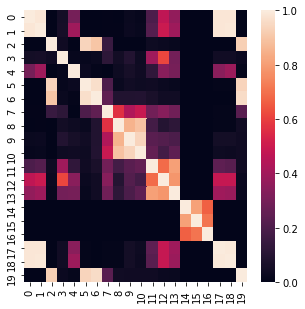

In [59]:
# Cosine similarity
sim_mat = cosine_similarity(prunned_hp_mn_mat)
fig = plt.figure(1, figsize =[5,5])
sea.heatmap(sim_mat)

In [85]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat)
clustered_order = plot_dendrogram(model, truncate_mode="level", p=len(hp_df_store)) # p truncate mode
clustered_order = np.array(clustered_order).astype(int) # convert strins into integers
print(clustered_order)

# plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
# plt.xlabel("index of point")
# plt.show()

[ 0 17  1 18  4  3 12 11 13  2  6  5 19 16 14 15  7  8  9 10]


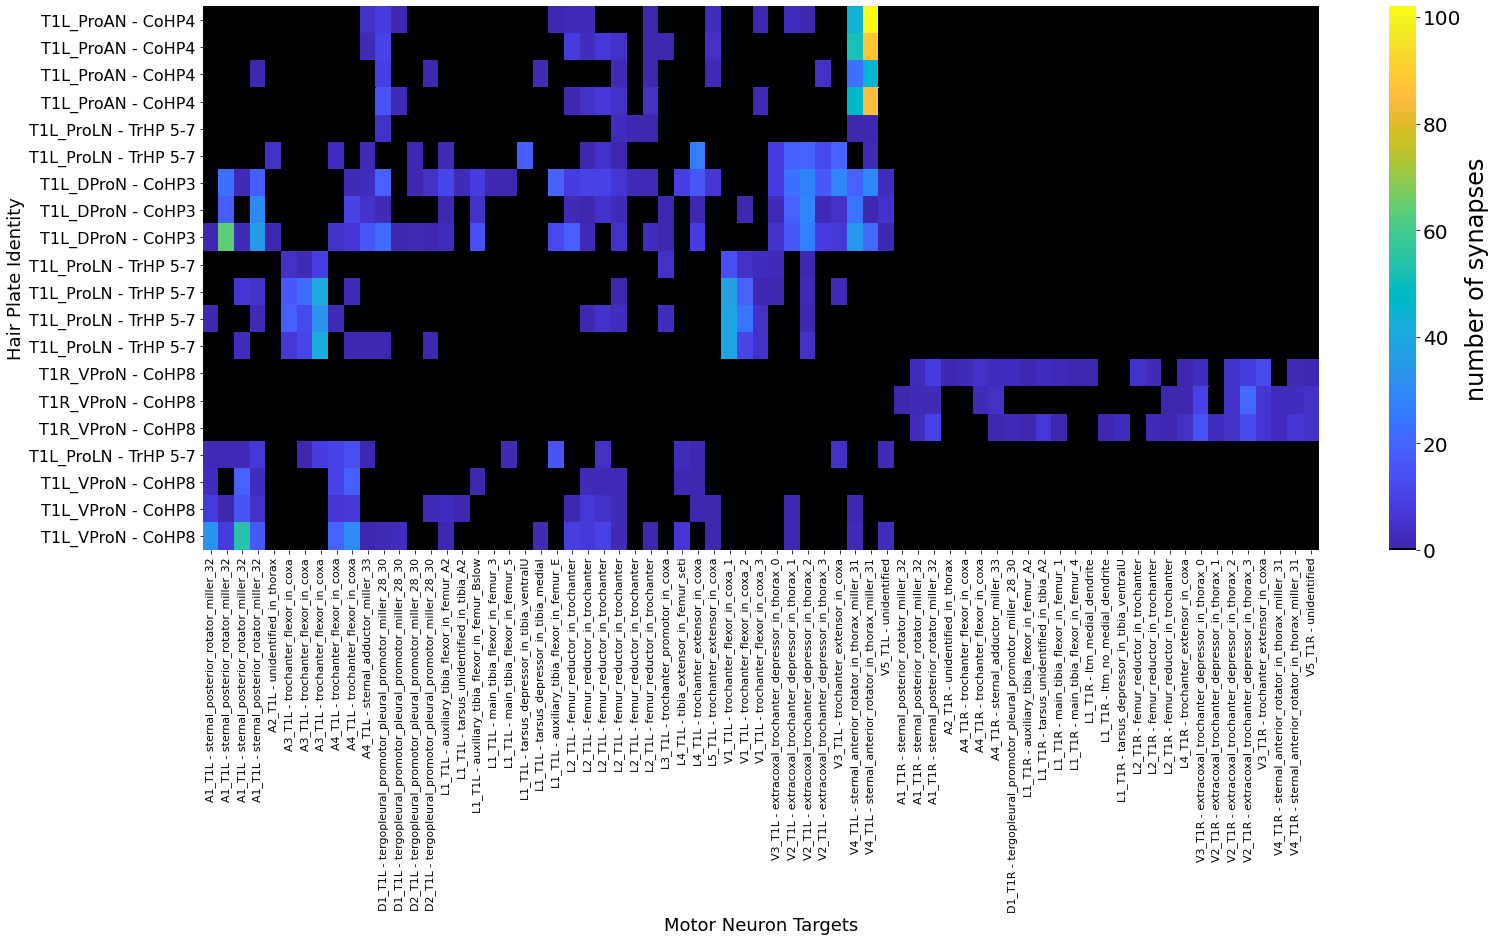

In [73]:
# reorder hairplate and motor neuron matrix
reorder_hp__mn_mat = prunned_hp_mn_mat[clustered_order, :]
# visualize prunned matrix
fig = plt.figure(1, figsize = [25,10])
ax = sea.heatmap(reorder_hp__mn_mat, xticklabels=remaining_mn_labels, yticklabels=np.array(hair_plate_identity)[clustered_order].tolist(), cmap=parula_map)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'number of synapses', size=24)
plt.xlabel('Motor Neuron Targets', fontsize =18)
plt.ylabel('Hair Plate Identity', fontsize =18)
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 11)
plt.show()
# fig.savefig('hairplate_motor_neuron_connectivity.png', dpi = 200, bbox_inches = 'tight')



<AxesSubplot:>

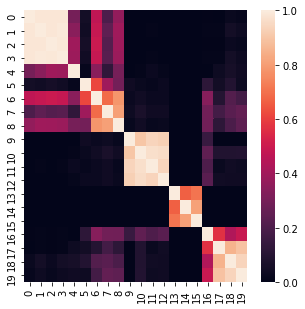

In [74]:
# reorder similarity matrix based on clustering results
reordered_sim_mat = cosine_similarity(reorder_hp__mn_mat)
fig = plt.figure(1, figsize =[5,5])
sea.heatmap(reordered_sim_mat)

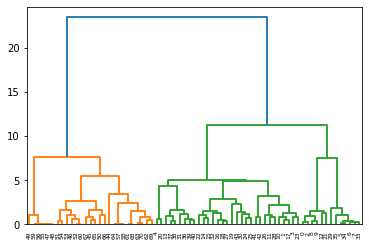

In [79]:
# After rearranging hair-plates, rearrange motor neurons by cosyne similarity
# Cosine similarity
sim_mat_2 = cosine_similarity(np.transpose(prunned_hp_mn_mat))

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat_2)
clustered_order_mns = plot_dendrogram(model, truncate_mode="level", p=len(mns)) # p truncate mode
clustered_order_mns = np.array(clustered_order_mns).astype(int) # convert strins into integers

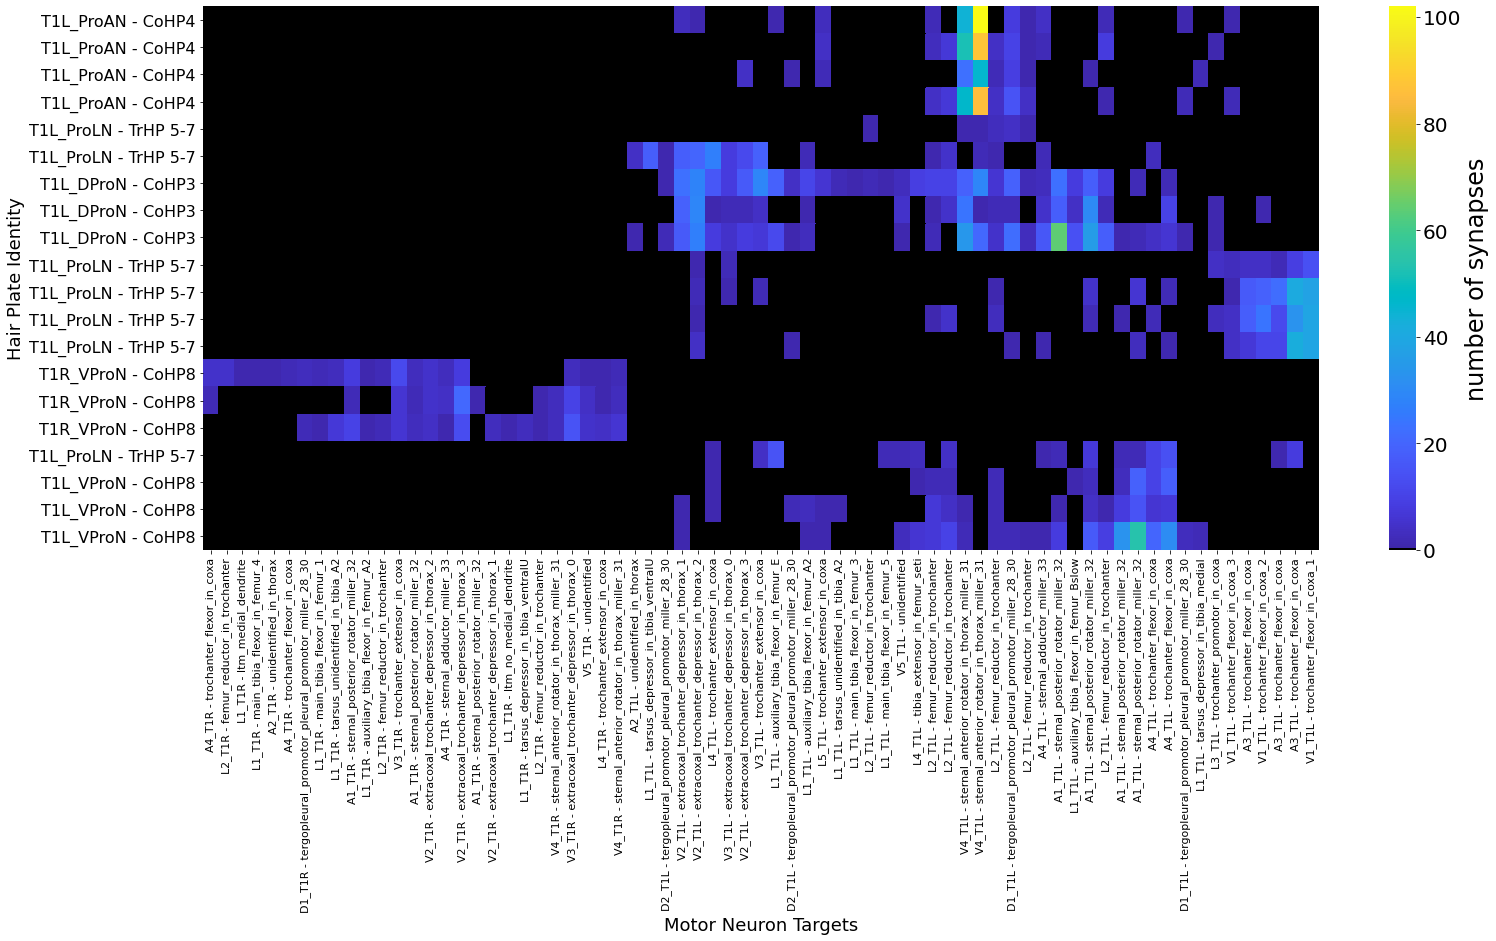

In [80]:
# reorder hairplate and motor neuron matrix
reordered_hp_mn_mat_2 = reorder_hp__mn_mat[:, clustered_order_mns]

# visualize prunned matrix
fig = plt.figure(1, figsize = [25,10])
ax = sea.heatmap(reordered_hp_mn_mat_2, xticklabels=np.array(remaining_mn_labels)[clustered_order_mns].tolist(), yticklabels=np.array(hair_plate_identity)[clustered_order].tolist(), cmap=parula_map)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'number of synapses', size=24)
plt.xlabel('Motor Neuron Targets', fontsize =18)
plt.ylabel('Hair Plate Identity', fontsize =18)
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 11)
plt.show()
# fig.savefig('hairplate_motor_neuron_connectivity.png', dpi = 200, bbox_inches = 'tight')



## Catelog Downstream and Upstream Partners

### Find downstream or upstream synaptic partners

downstream partners = pre_ids

upstream partners = post_ids

In [14]:
# Get post synapse information for get of the hair plates
print(client.materialize.synapse_table)
post_synapse_df = client.materialize.synapse_query(pre_ids = hair_plate_neurons) # Takes list
# lets post the shape to see how many synapses we have
print(post_synapse_df.shape)
# and take a peak at the whole dataframe
post_synapse_df.head()

synapses_jan2022
(67666, 9)


,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,score,pre_pt_position,post_pt_position
0,169536,t,72975687321283940,648518346496227925,72975687321283930,648518346442595494,23,"[26905, 99827, 2146]","[26907, 99793, 2147]"
1,382495,t,72694693783627651,648518346489643225,72694693783637620,648518346524056837,16,"[19275, 114175, 2944]","[19239, 114157, 2946]"
2,382643,t,72694693783586941,648518346489643225,72694693783567417,648518346483194788,14,"[19305, 114283, 2920]","[19341, 114263, 2920]"
3,570357,t,72342643434231178,648518346493028338,72342643434277405,648518346491272152,25,"[9309, 106823, 1938]","[9343, 106827, 1937]"
4,597229,t,72694762435849810,648518346511678064,72694762435845121,648518346502299731,33,"[19323, 116013, 2751]","[19319, 115977, 2752]"


In [15]:
# Create a dataframe with presynaptic ID, Postsynaptic ID, and number of synapses
hp_df_store =[]
cat_cnt = 0
for hp_id in hair_plate_neurons:
    # hair plate specific data frame sorted by the strongest synapse
    hp_post_df = post_synapse_df[post_synapse_df['pre_pt_root_id'] == hp_id]
    hp_post_synapses = hp_post_df.groupby(['pre_pt_root_id','post_pt_root_id'])['post_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)
    
    # append this dataframe
    hp_df_store.append(hp_post_synapses)
    
    # concatenate dataframes
    if cat_cnt == 0:
        cat_df = hp_post_synapses
        cat_cnt=1
    else:
        cat_df = pd.concat([cat_df, hp_post_synapses], ignore_index=True)

In [16]:
# find postsynaptic partners that recieve common input from from hair plates
common_hp_input = cat_df.groupby(['post_pt_root_id'])['post_pt_root_id'].count().reset_index(name="hp_common_input").sort_values(by=['hp_common_input'], ascending=False).reset_index(drop=True)
common_hp_input_filtered = common_hp_input[common_hp_input["hp_common_input"]>1] # filter out postsynaptic partners that don't share a lot of common input
common_hp_input_filtered

,post_pt_root_id,hp_common_input
0,648518346476891152,18
1,648518346483175588,17
2,648518346489626719,16
3,648518346493703928,16
4,648518346483176612,14
...,...,...
2725,648518346430360071,2
2726,648518346427220298,2
2727,648518346438085629,2
2728,648518346499185430,2


In [17]:
# Get presynaptic (hair plat seg ids) given strongest common inputs onto downstream neuron
for downstream_neuron in range(common_hp_input_filtered['post_pt_root_id'].shape[0]):
    dw_neuron_id = common_hp_input_filtered['post_pt_root_id'][downstream_neuron]
    hp_ids = []
    for hp in range(len(hp_df_store)):
        curr_hp_df = hp_df_store[hp]
        if len(np.where(curr_hp_df['post_pt_root_id'] == dw_neuron_id)[0]) > 0:
            hp_ids.append([curr_hp_df['pre_pt_root_id'][0],hair_plate_identity[hp]])
    
    # create or append to a dataframe
    if downstream_neuron == 0:
        hp_dwn_id_df = pd.DataFrame(data={'downstream_neuron_id': [dw_neuron_id], 'hairplate_neurons': [hp_ids]})
    else:
        hp_dwn_id_df = pd.concat([hp_dwn_id_df, pd.DataFrame(data={'downstream_neuron_id': [dw_neuron_id], 'hairplate_neurons': [hp_ids]})])

hp_dwn_id_df = hp_dwn_id_df.reset_index(drop=True)
hp_dwn_id_df

,downstream_neuron_id,hairplate_neurons
0,648518346476891152,"[[648518346498320945, T1L_ProAN - CoHP4], [648..."
1,648518346483175588,"[[648518346498320945, T1L_ProAN - CoHP4], [648..."
2,648518346489626719,"[[648518346498320945, T1L_ProAN - CoHP4], [648..."
3,648518346493703928,"[[648518346498320945, T1L_ProAN - CoHP4], [648..."
4,648518346483176612,"[[648518346498320945, T1L_ProAN - CoHP4], [648..."
...,...,...
2725,648518346430360071,"[[648518346511678064, T1L_DProN - CoHP3], [648..."
2726,648518346427220298,"[[648518346484630429, T1R_VProN - CoHP8], [648..."
2727,648518346438085629,"[[648518346498320945, T1L_ProAN - CoHP4], [648..."
2728,648518346499185430,"[[648518346501717065, T1L_ProLN - TrHP 5-7], [..."


In [14]:
# find hair plate neuron ids common to a downstream partner
downstream_id = 648518346486034056
print(*hp_dwn_id_df['hairplate_neurons'][hp_dwn_id_df['downstream_neuron_id'] == downstream_id].tolist()[0], sep='\n')

[648518346496227925, 'CoHP4']
[648518346465846832, 'CoHP8']
[648518346491896594, 'CoHP8']
[648518346511678064, 'CoHP3']
[648518346483083940, 'CoHP3']
[648518346483962397, 'CoHP3']


### Find the intersection (inner join) between number of synapses and common inputs

In [20]:
hp_join_store = []
num_syn_threshold = 10
for hp in range(len(hp_df_store)):
    hp_df = hp_df_store[hp]
    syn_common_input_join = pd.merge(hp_df,common_hp_input_filtered,on='post_pt_root_id')
    filtered_join = syn_common_input_join[syn_common_input_join['number_of_synapses']>=num_syn_threshold]
    hp_join_store.append(filtered_join)

In [58]:
# Display top postsynaptic partners for each hair plate
hp_neuron_num = 19
print(hair_plate_identity[hp_neuron_num])
hp_join_store[hp_neuron_num]

T1L_ProLN - TrHP 5-7


,pre_pt_root_id,post_pt_root_id,number_of_synapses,hp_common_input
0,648518346479415488,648518346496857752,49,9
1,648518346479415488,648518346483112382,42,5
2,648518346479415488,648518346489322585,39,4
3,648518346479415488,648518346485804670,35,7
4,648518346479415488,648518346494094962,23,7
5,648518346479415488,648518346480238139,22,5
6,648518346479415488,648518346494651811,20,6
7,648518346479415488,648518346493092928,19,7
8,648518346479415488,648518346504381420,19,11
9,648518346479415488,648518346524056837,16,10


### Repeat the above procedure but for upstream partners

In [21]:
# Get post synapse information for get of the hair plates
print(client.materialize.synapse_table)
post_synapse_df = client.materialize.synapse_query(post_ids = hair_plate_neurons) # Takes list
# lets post the shape to see how many synapses we have
print(post_synapse_df.shape)
# and take a peak at the whole dataframe
post_synapse_df.head()

synapses_may2021
(3374, 9)


,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,score,pre_pt_position,post_pt_position
0,3559011,t,72553543307064410,648518346491896594,72553543307085869,648518346486034056,35,"[15541, 102187, 1558]","[15543, 102187, 1562]"
1,3837667,t,72834881650371161,648518346494604363,72834881650371130,648518346465846832,40,"[24179, 96365, 3190]","[24179, 96329, 3189]"
3,13288351,t,72554024813240295,648518346367932216,72554024813262627,648518346517170213,22,"[14733, 115585, 2493]","[14735, 115575, 2498]"
4,14422587,t,72624393557498150,648518346496227925,72624393557503478,648518346486034056,19,"[16533, 115439, 2521]","[16545, 115471, 2523]"
5,15481748,t,72482969008697322,648518346495191990,72482969008836154,648518346493028338,31,"[13341, 94745, 2815]","[13351, 94765, 2817]"


In [22]:
# Create a dataframe with presynaptic ID, Postsynaptic ID, and number of synapses
hp_df_store =[]
cat_cnt = 0
for hp_id in hair_plate_neurons:
    # hair plate specific data frame sorted by the strongest synapse
    hp_post_df = post_synapse_df[post_synapse_df['post_pt_root_id'] == hp_id]
    hp_post_synapses = hp_post_df.groupby(['pre_pt_root_id','post_pt_root_id'])['pre_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)
    
    # append this dataframe
    hp_df_store.append(hp_post_synapses)
    
    # concatenate dataframes
    if cat_cnt == 0:
        cat_df = hp_post_synapses
        cat_cnt=1
    else:
        cat_df = pd.concat([cat_df, hp_post_synapses], ignore_index=True)

In [86]:
hp_df_store[0]

,pre_pt_root_id,post_pt_root_id,number_of_synapses
0,648518346484096295,648518346496227925,12
1,648518346493727089,648518346496227925,10
2,648518346489592268,648518346496227925,9
3,648518346489643225,648518346496227925,7
4,648518346500488883,648518346496227925,5
...,...,...,...
77,648518346490500093,648518346496227925,1
78,648518346364627901,648518346496227925,1
79,648518346491772507,648518346496227925,1
80,648518346491965543,648518346496227925,1


In [23]:
# find postsynaptic partners that recieve common input from from hair plates
common_hp_input = cat_df.groupby(['pre_pt_root_id'])['pre_pt_root_id'].count().reset_index(name="hp_common_input").sort_values(by=['hp_common_input'], ascending=False).reset_index(drop=True)
common_hp_input_filtered = common_hp_input[common_hp_input["hp_common_input"]>1] # filter out postsynaptic partners that don't share a lot of common input
common_hp_input_filtered

,pre_pt_root_id,hp_common_input
0,648518346493727089,14
1,648518346494664363,14
2,648518346493937163,13
3,648518346511678064,13
4,648518346484096295,12
...,...,...
256,648518346436363527,2
257,648518346442923582,2
258,648518346355243080,2
259,648518346434770317,2


In [24]:
# Get presynaptic (hair plat seg ids) given strongest common inputs onto downstream neuron
for downstream_neuron in range(common_hp_input_filtered['pre_pt_root_id'].shape[0]):
    dw_neuron_id = common_hp_input_filtered['pre_pt_root_id'][downstream_neuron]
    hp_ids = []
    for hp in range(len(hp_df_store)):
        curr_hp_df = hp_df_store[hp]
        if len(np.where(curr_hp_df['pre_pt_root_id'] == dw_neuron_id)[0]) > 0:
            hp_ids.append([curr_hp_df['post_pt_root_id'][0],hair_plate_identity[hp]])
    
    # create or append to a dataframe
    if downstream_neuron == 0:
        hp_dwn_id_df = pd.DataFrame(data={'upstream_neuron_id': [dw_neuron_id], 'hairplate_neurons': [hp_ids]})
    else:
        hp_dwn_id_df = pd.concat([hp_dwn_id_df, pd.DataFrame(data={'upstream_neuron_id': [dw_neuron_id], 'hairplate_neurons': [hp_ids]})])

hp_dwn_id_df = hp_dwn_id_df.reset_index(drop=True)
hp_dwn_id_df

,upstream_neuron_id,hairplate_neurons
0,648518346493727089,"[[648518346496227925, CoHP4], [648518346489643..."
1,648518346494664363,"[[648518346496227925, CoHP4], [648518346489643..."
2,648518346493937163,"[[648518346496227925, CoHP4], [648518346489643..."
3,648518346511678064,"[[648518346496227925, CoHP4], [648518346489643..."
4,648518346484096295,"[[648518346496227925, CoHP4], [648518346489643..."
...,...,...
256,648518346436363527,"[[648518346500488883, TrHP], [6485183465171702..."
257,648518346442923582,"[[648518346517170213, TrHP], [6485183464839623..."
258,648518346355243080,"[[648518346511678064, CoHP3], [648518346483962..."
259,648518346434770317,"[[648518346517170213, TrHP], [6485183465116780..."


In [30]:
# find hair plate neuron ids common to a downstream partner
downstream_id = 648518346498315313
print(*hp_dwn_id_df['hairplate_neurons'][hp_dwn_id_df['upstream_neuron_id'] == downstream_id].tolist()[0], sep='\n')

[648518346483083940, 'CoHP3']
[648518346483962397, 'CoHP3']


In [25]:
hp_join_store = []
num_syn_threshold = 3
for hp in range(len(hp_df_store)):
    hp_df = hp_df_store[hp]
    syn_common_input_join = pd.merge(hp_df,common_hp_input_filtered,on='pre_pt_root_id')
    filtered_join = syn_common_input_join[syn_common_input_join['number_of_synapses']>=num_syn_threshold]
    hp_join_store.append(filtered_join)

In [31]:
#### Display top postsynaptic partners for each hair plate
hp_neuron_num = 16
print(hair_plate_identity[hp_neuron_num])
hp_join_store[hp_neuron_num]

CoHP3


,pre_pt_root_id,post_pt_root_id,number_of_synapses,hp_common_input
0,648518346475391924,648518346483962397,14,9
1,648518346498315313,648518346483962397,9,2
2,648518346486685205,648518346483962397,7,7
3,648518346493669880,648518346483962397,6,11
4,648518346520600535,648518346483962397,5,5
5,648518346486189993,648518346483962397,5,12
6,648518346494664363,648518346483962397,4,14
7,648518346517383204,648518346483962397,4,8
8,648518346517170213,648518346483962397,4,8
9,648518346484096295,648518346483962397,4,12
